In [2]:
import pandas as pd
import numpy as np
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset": 'stix',
    "font.family":'DejaVu Sans',
    "font.family": 'serif',
    "font.serif": ['Arial'],
    "font.size": 24,
    'axes.unicode_minus': False
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False
large = 22
med = 16
small = 12
params = {
    'axes.titlesize': large,
    'legend.fontsize': med,
    'figure.figsize': (8, 6),
    'axes.labelsize': med,
    'axes.titlesize': med,
    'xtick.labelsize': med,
    'ytick.labelsize': med,
    'figure.titlesize': large
}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300
seed = 42

In [11]:
df = pd.read_csv('./data/SLME.csv')
df

jid  formula  spg_number  formation_energy_peratom  \
0      JVASP-1996      NaI         225                  -1.35798   
1     JVASP-21210       Xe         225                   0.00009   
2      JVASP-1390      SrO         225                  -3.02565   
3     JVASP-90336  Sr2H6Os         225                  -0.62937   
4     JVASP-37031  TiFe2Sb         225                  -0.23465   
..            ...      ...         ...                       ...   
736  JVASP-150063     TePb         225                  -0.42955   
737  JVASP-149870      PbS         225                  -0.64352   
738  JVASP-150333  Li2H6Pt         225                  -0.37666   
739  JVASP-149916     SnTe         225                  -0.32578   
740  JVASP-154234     BiF3         225                  -2.39022   

     optb88vdw_bandgap   ehull   slme  
0                3.851  0.0090   0.00  
1                6.149  0.0000   0.00  
2                3.405  0.0000   0.00  
3                2.398  0.0000   5.95  
4                0.000  0.0465   5.84  
..                 ...     ...    ...  
736              0.838  0.0001  33.68  
737              0.722  0.0124  33.60  
738              3.011  0.0000   0.80  
739              0.479  0.0000  17.24  
740              4.148  0.2009   0.00  

[741 rows x 7 columns]

In [7]:
df['y'] = df['slme'].astype(float).map(lambda x: 1 if x>=20 else 0)
df['y'].value_counts()

y
0    508
1    233
Name: count, dtype: int64

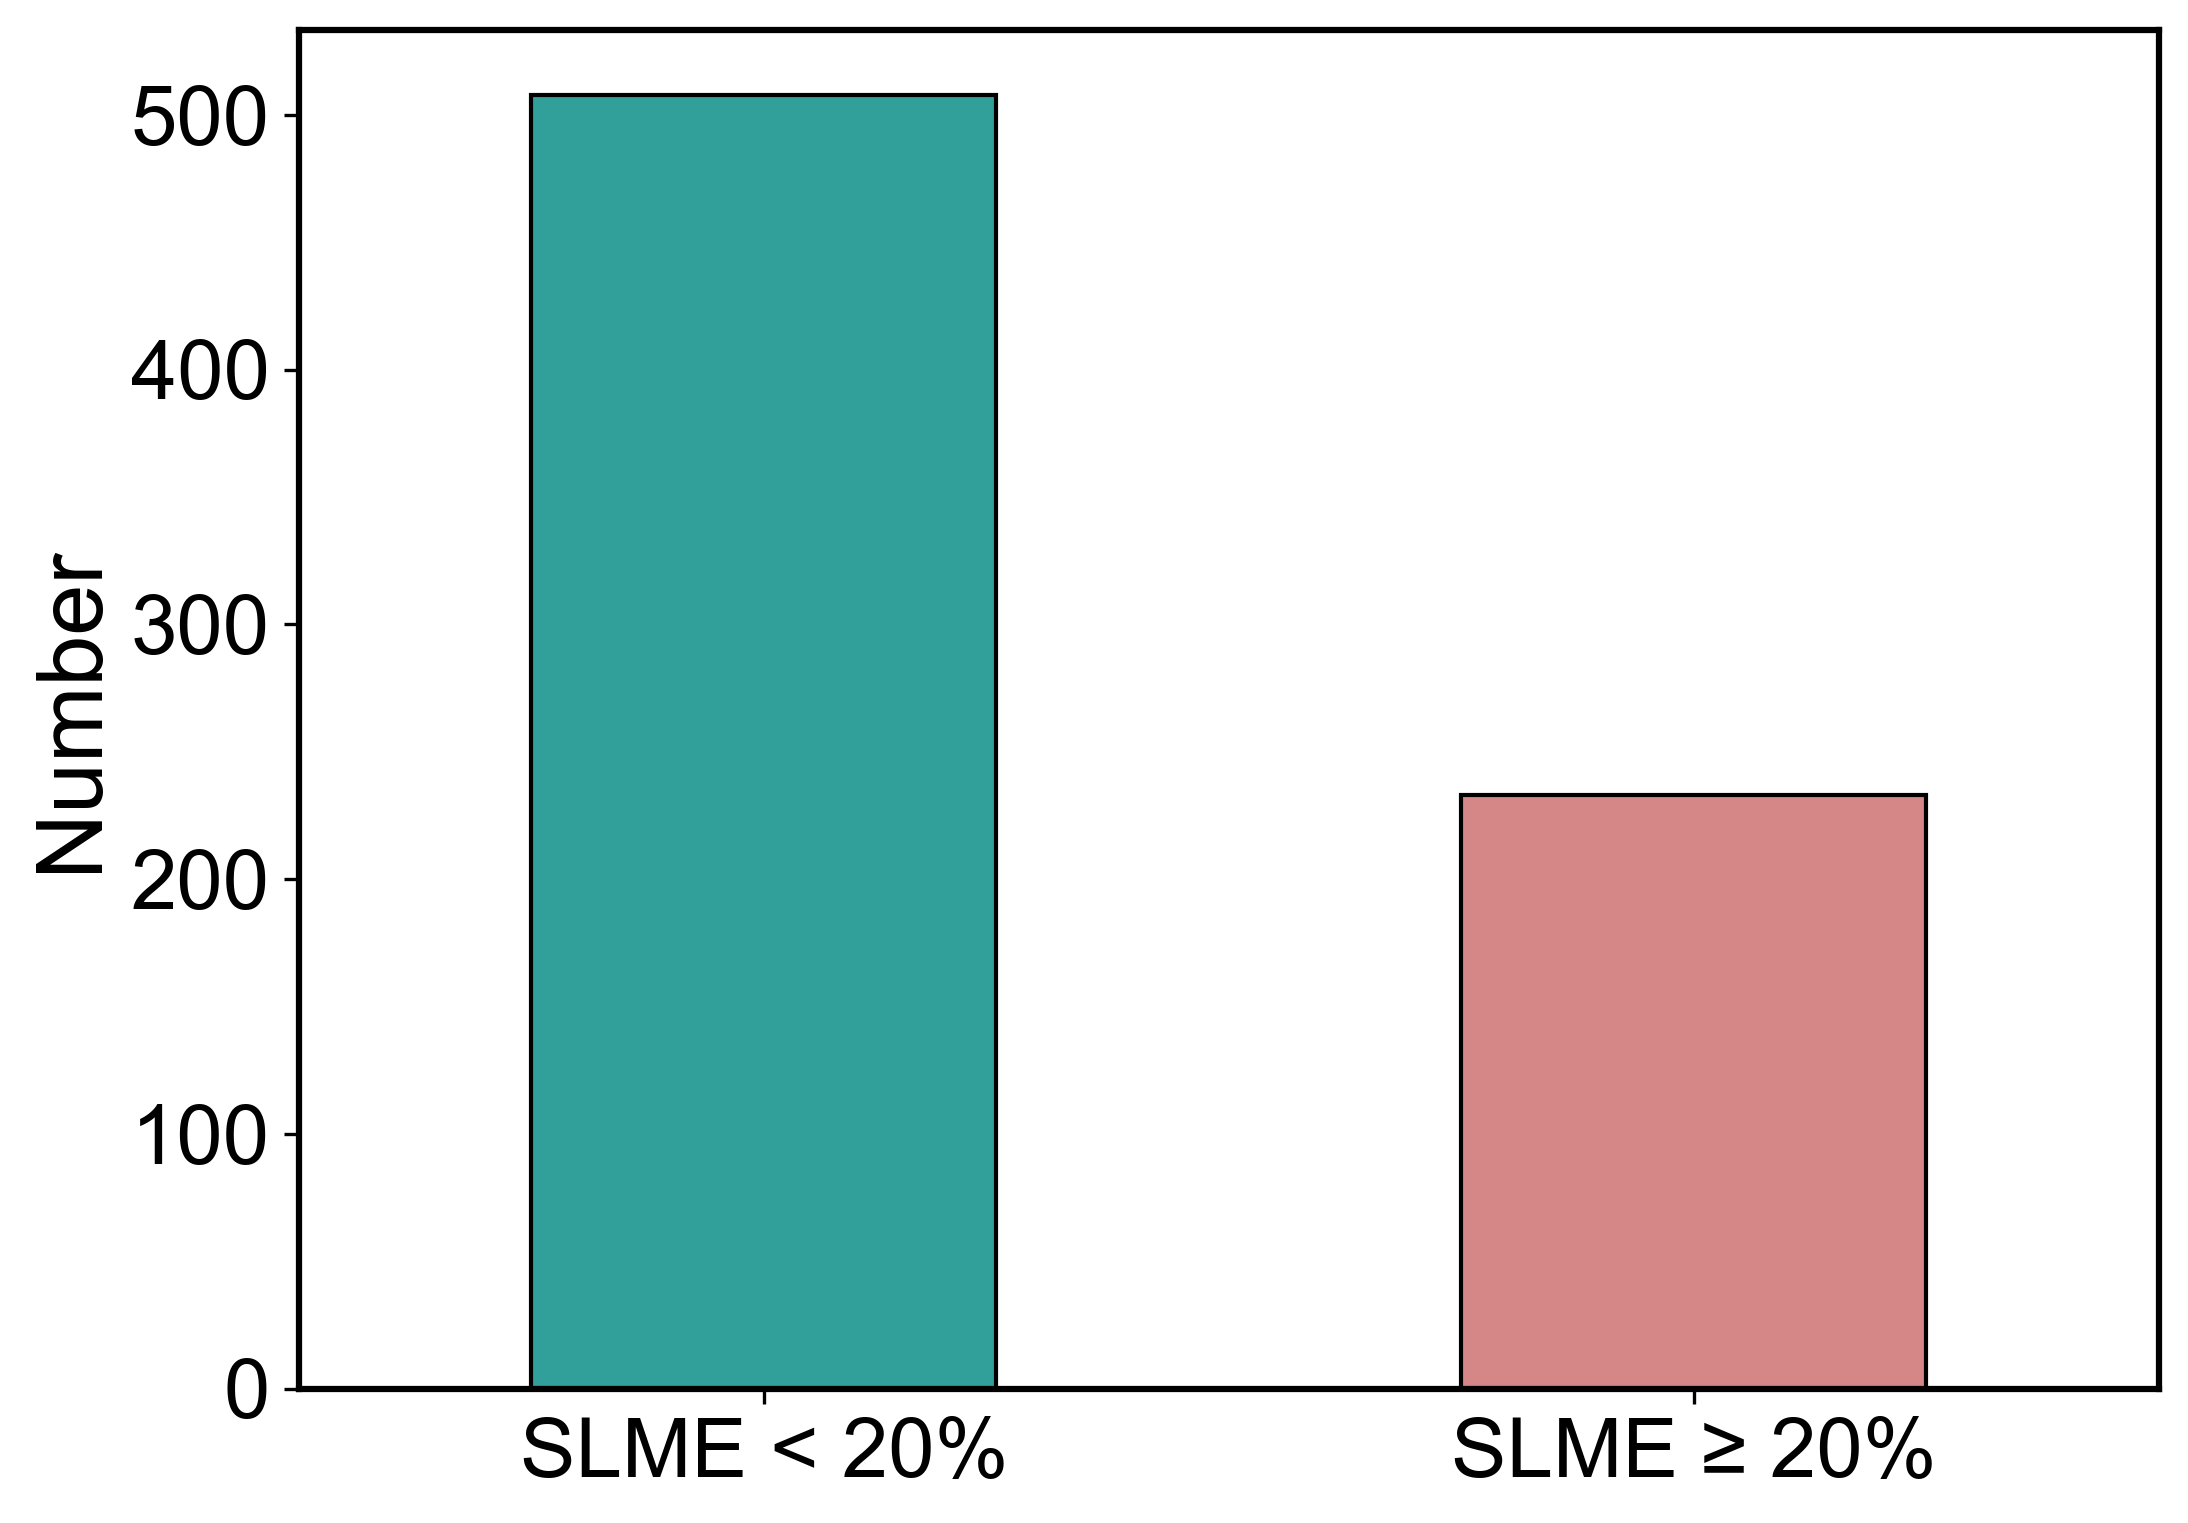

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

y_counts = df['y'].value_counts()
y_counts.plot(kind='bar', color=['#31A09A', '#D58686'],edgecolor='black')
plt.ylabel('Number', fontsize=22)
plt.xticks(ticks=[0, 1], labels=['SLME < 20%', 'SLME ≥ 20%'], rotation=0, fontsize=22)

ax = plt.gca() 
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=20)  # 让刻度数字更大
ax.set_xlabel('') 
plt.savefig('./picture/slme_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def remove_collinear_features(x, threshold):
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [9]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen.core import Composition
feature_calculators = MultipleFeaturizer([cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()
df['composition'] = df['formula'].map(Composition)
data_features = feature_calculators.featurize_dataframe(df,col_id='composition')

X = data_features[feature_labels]
y = df['y']
X = remove_collinear_features(X, 0.8)
X = pd.concat([df['spg_number'],X ], axis=1)
X = pd.concat([df['formation_energy_peratom'],X ], axis=1)
feature_labels = X.columns

MultipleFeaturizer:   0%|          | 0/741 [00:00<?, ?it/s]

In [10]:
X

formation_energy_peratom  spg_number  MagpieData minimum Number  \
0                    -1.35798         225                       11.0   
1                     0.00009         225                       54.0   
2                    -3.02565         225                        8.0   
3                    -0.62937         225                        1.0   
4                    -0.23465         225                       22.0   
..                        ...         ...                        ...   
736                  -0.42955         225                       52.0   
737                  -0.64352         225                       16.0   
738                  -0.37666         225                        1.0   
739                  -0.32578         225                       50.0   
740                  -2.39022         225                        9.0   

     MagpieData maximum Number  MagpieData range Number  \
0                         53.0                     42.0   
1                         54.0                      0.0   
2                         38.0                     30.0   
3                         76.0                     75.0   
4                         51.0                     29.0   
..                         ...                      ...   
736                       82.0                     30.0   
737                       82.0                     66.0   
738                       78.0                     77.0   
739                       52.0                      2.0   
740                       83.0                     74.0   

     MagpieData avg_dev Number  MagpieData minimum MendeleevNumber  \
0                    21.000000                                 2.0   
1                     0.000000                               102.0   
2                    15.000000                                 8.0   
3                    22.074074                                 8.0   
4                     9.875000                                43.0   
..                         ...                                 ...   
736                  15.000000                                81.0   
737                  33.000000                                81.0   
738                  15.111111                                 1.0   
739                   1.000000                                80.0   
740                  27.750000                                86.0   

     MagpieData maximum MendeleevNumber  MagpieData mean MendeleevNumber  \
0                                  96.0                        49.000000   
1                                 102.0                       102.000000   
2                                  87.0                        47.500000   
3                                  92.0                        69.444444   
4                                  85.0                        59.500000   
..                                  ...                              ...   
736                                90.0                        85.500000   
737                                88.0                        84.500000   
738                                92.0                        68.555556   
739                                90.0                        85.000000   
740                                93.0                        91.250000   

     MagpieData mode MendeleevNumber  MagpieData minimum MeltingT  \
0                                2.0                       370.87   
1                              102.0                       161.30   
2                                8.0                        54.80   
3                               92.0                        14.01   
4                               55.0                       903.78   
..                               ...                          ...   
736                             81.0                       600.61   
737                             81.0                       388.36   
738                             92.0                    

In [11]:
X.columns = X.columns.str.replace(' ', '_')
X['compound_possible'] = X['compound_possible'].replace({True: 1, False: 0})

In [12]:
X = X.fillna(0)

In [13]:
y = df['y']

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
seed =42
kn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(n_jobs=-1,random_state=seed)
mlp = MLPClassifier(alpha=1, max_iter=1000,random_state=seed)
lgbm = LGBMClassifier(random_state=seed,verbose=0)
xb = XGBClassifier(random_state=seed,n_jobs=-1)
ext = ExtraTreesClassifier(n_jobs=-1,random_state=seed) 
gbc = GradientBoostingClassifier(random_state=seed)
gnb = GaussianNB()

In [15]:
#no smote
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
def fold5(model, X, y, name='', is_plot=True):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models = []  
    accuracies = []
    f1s = []
    mccs = []
    roc_aucs = []
    recalls = []
    fig, ax = plt.subplots()
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        try:
            X = X.values
            y = y.values
        except:
            pass
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
       
        model.fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        mcc = metrics.matthews_corrcoef(y_test, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        recall = metrics.recall_score(y_test, y_pred)
        print(f"Fold {i+ 1} Accuracy: {accuracy} F1_Score: {f1}  ROC_AUC: {roc_auc}")

        accuracies.append(accuracy)
        f1s.append(f1)
        mccs.append(mcc)
        roc_aucs.append(roc_auc)
        recalls.append(recall)

        if is_plot:
            ax.plot(fpr, tpr, label=f"Fold {i+1} (AUC = {roc_auc:.3f})", lw=1.7, linestyle="-.", alpha=0.75)
            ax.plot([0, 1], [0, 1], "r--", lw=1, alpha=0.8)
            ax.set_xlim([-0.02, 1.0])
            ax.set_ylim([0.6, 1.05])
            ax.set_xlabel("False Positive Rate", fontsize=22)
            ax.set_ylabel("True Positive Rate", fontsize=22)
           # ax.set_title(f"ROC Curves: {name}", fontweight="bold")
            ax.legend(loc="lower right" ,fontsize=17)
            ax.grid(True, linestyle="--", linewidth=1, alpha=0.5)
            ax.spines["top"].set_linewidth(1.5)
            ax.spines["bottom"].set_linewidth(1.5)
            ax.spines["left"].set_linewidth(1.5)
            ax.spines["right"].set_linewidth(1.5)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.grid(False)

    result = {
        'accuracy': np.mean(accuracies),
        'f1-score': np.mean(f1s),
        'mcc': np.mean(mccs),
        'roc_auc': np.mean(roc_aucs),
        'recall': np.mean(recalls)        }
    if is_plot:
        #plt.savefig('./picture/slme_nosmote.png', dpi=300, bbox_inches='tight')
        plt.show()
    return result, models

Fold 1 Accuracy: 0.8389261744966443 F1_Score: 0.7073170731707318  ROC_AUC: 0.8745306633291614
Fold 2 Accuracy: 0.8648648648648649 F1_Score: 0.761904761904762  ROC_AUC: 0.9310528559249787
Fold 3 Accuracy: 0.8513513513513513 F1_Score: 0.7441860465116279  ROC_AUC: 0.8589087809036658
Fold 4 Accuracy: 0.8378378378378378 F1_Score: 0.7333333333333334  ROC_AUC: 0.8915104276385085
Fold 5 Accuracy: 0.8175675675675675 F1_Score: 0.6966292134831461  ROC_AUC: 0.8810827891299768


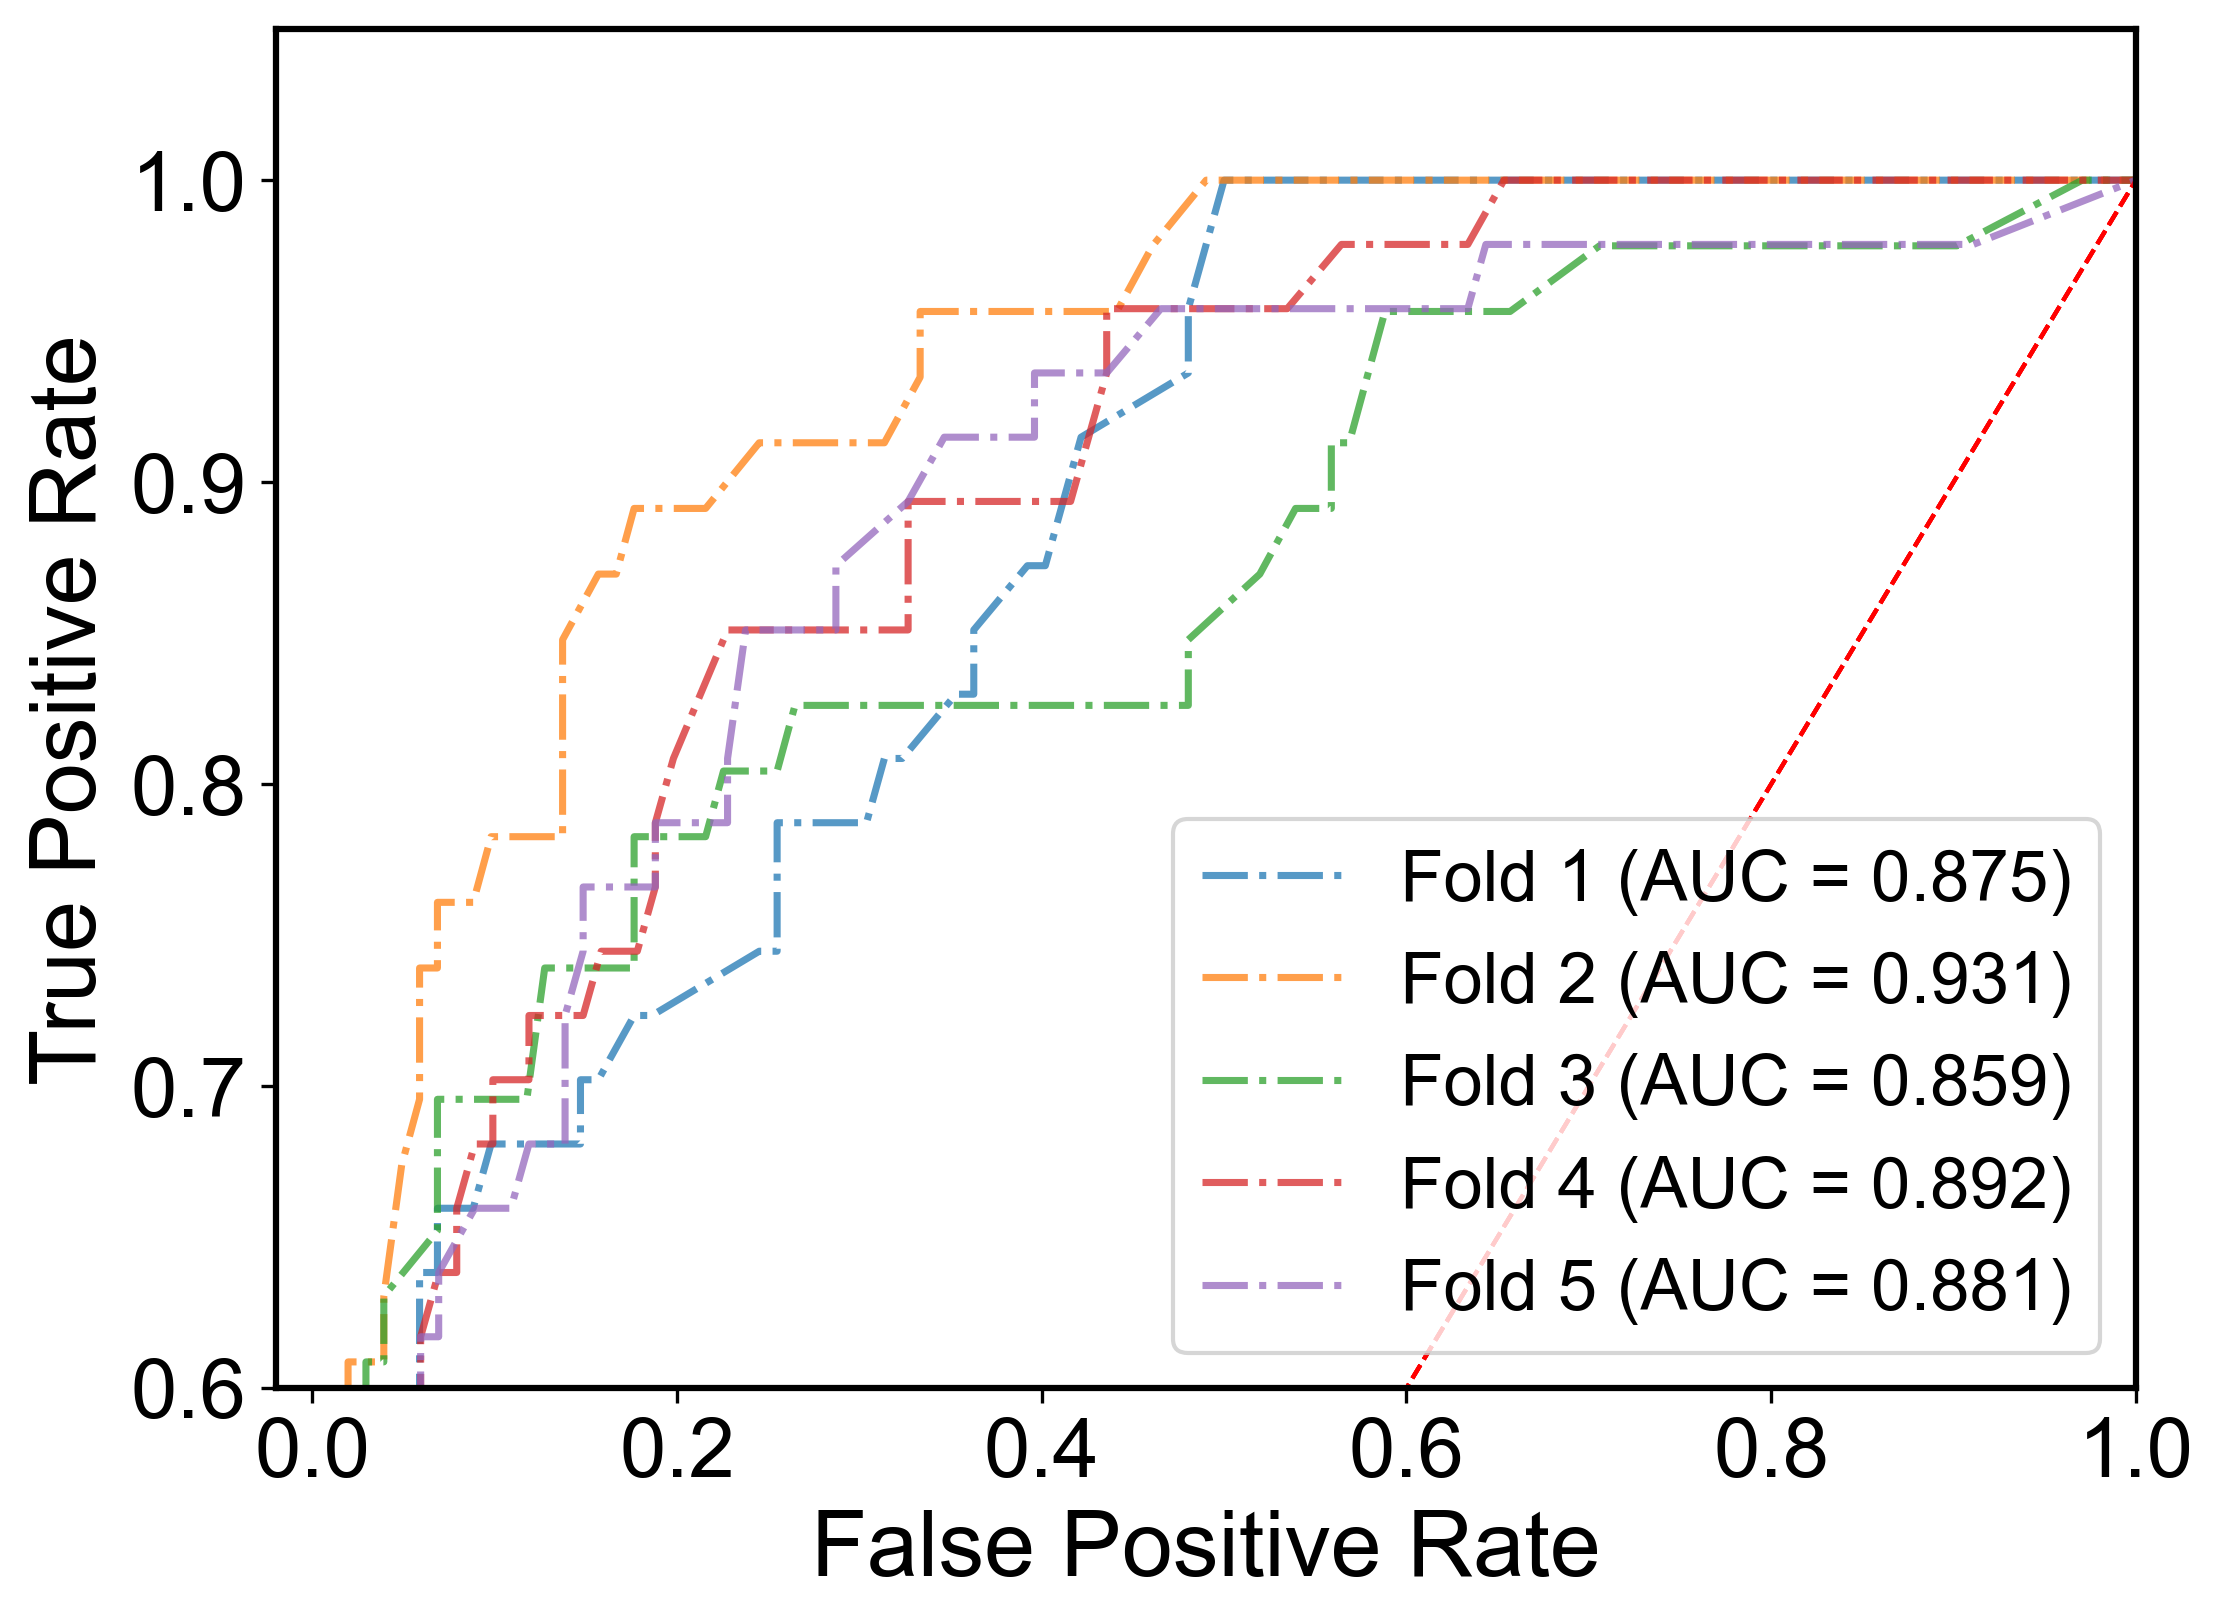

({'accuracy': 0.8421095592236532,
  'f1-score': 0.7286740856807202,
  'mcc': 0.623368655719512,
  'roc_auc': 0.8874171033852581,
  'recall': 0.6740055504162812},
 [RandomForestClassifier(n_jobs=-1, random_state=42),
  RandomForestClassifier(n_jobs=-1, random_state=42),
  RandomForestClassifier(n_jobs=-1, random_state=42),
  RandomForestClassifier(n_jobs=-1, random_state=42),
  RandomForestClassifier(n_jobs=-1, random_state=42)])

In [16]:
fold5(rf, X, y)

Fold 1 Accuracy: 0.8322147651006712 F1_Score: 0.7126436781609196  ROC_AUC: 0.8633708802670005
Fold 2 Accuracy: 0.8581081081081081 F1_Score: 0.7586206896551724  ROC_AUC: 0.9338235294117647
Fold 3 Accuracy: 0.8513513513513513 F1_Score: 0.75  ROC_AUC: 0.8854433077578858
Fold 4 Accuracy: 0.8378378378378378 F1_Score: 0.7391304347826088  ROC_AUC: 0.9044659785127448
Fold 5 Accuracy: 0.8378378378378378 F1_Score: 0.7333333333333334  ROC_AUC: 0.8909837792289867


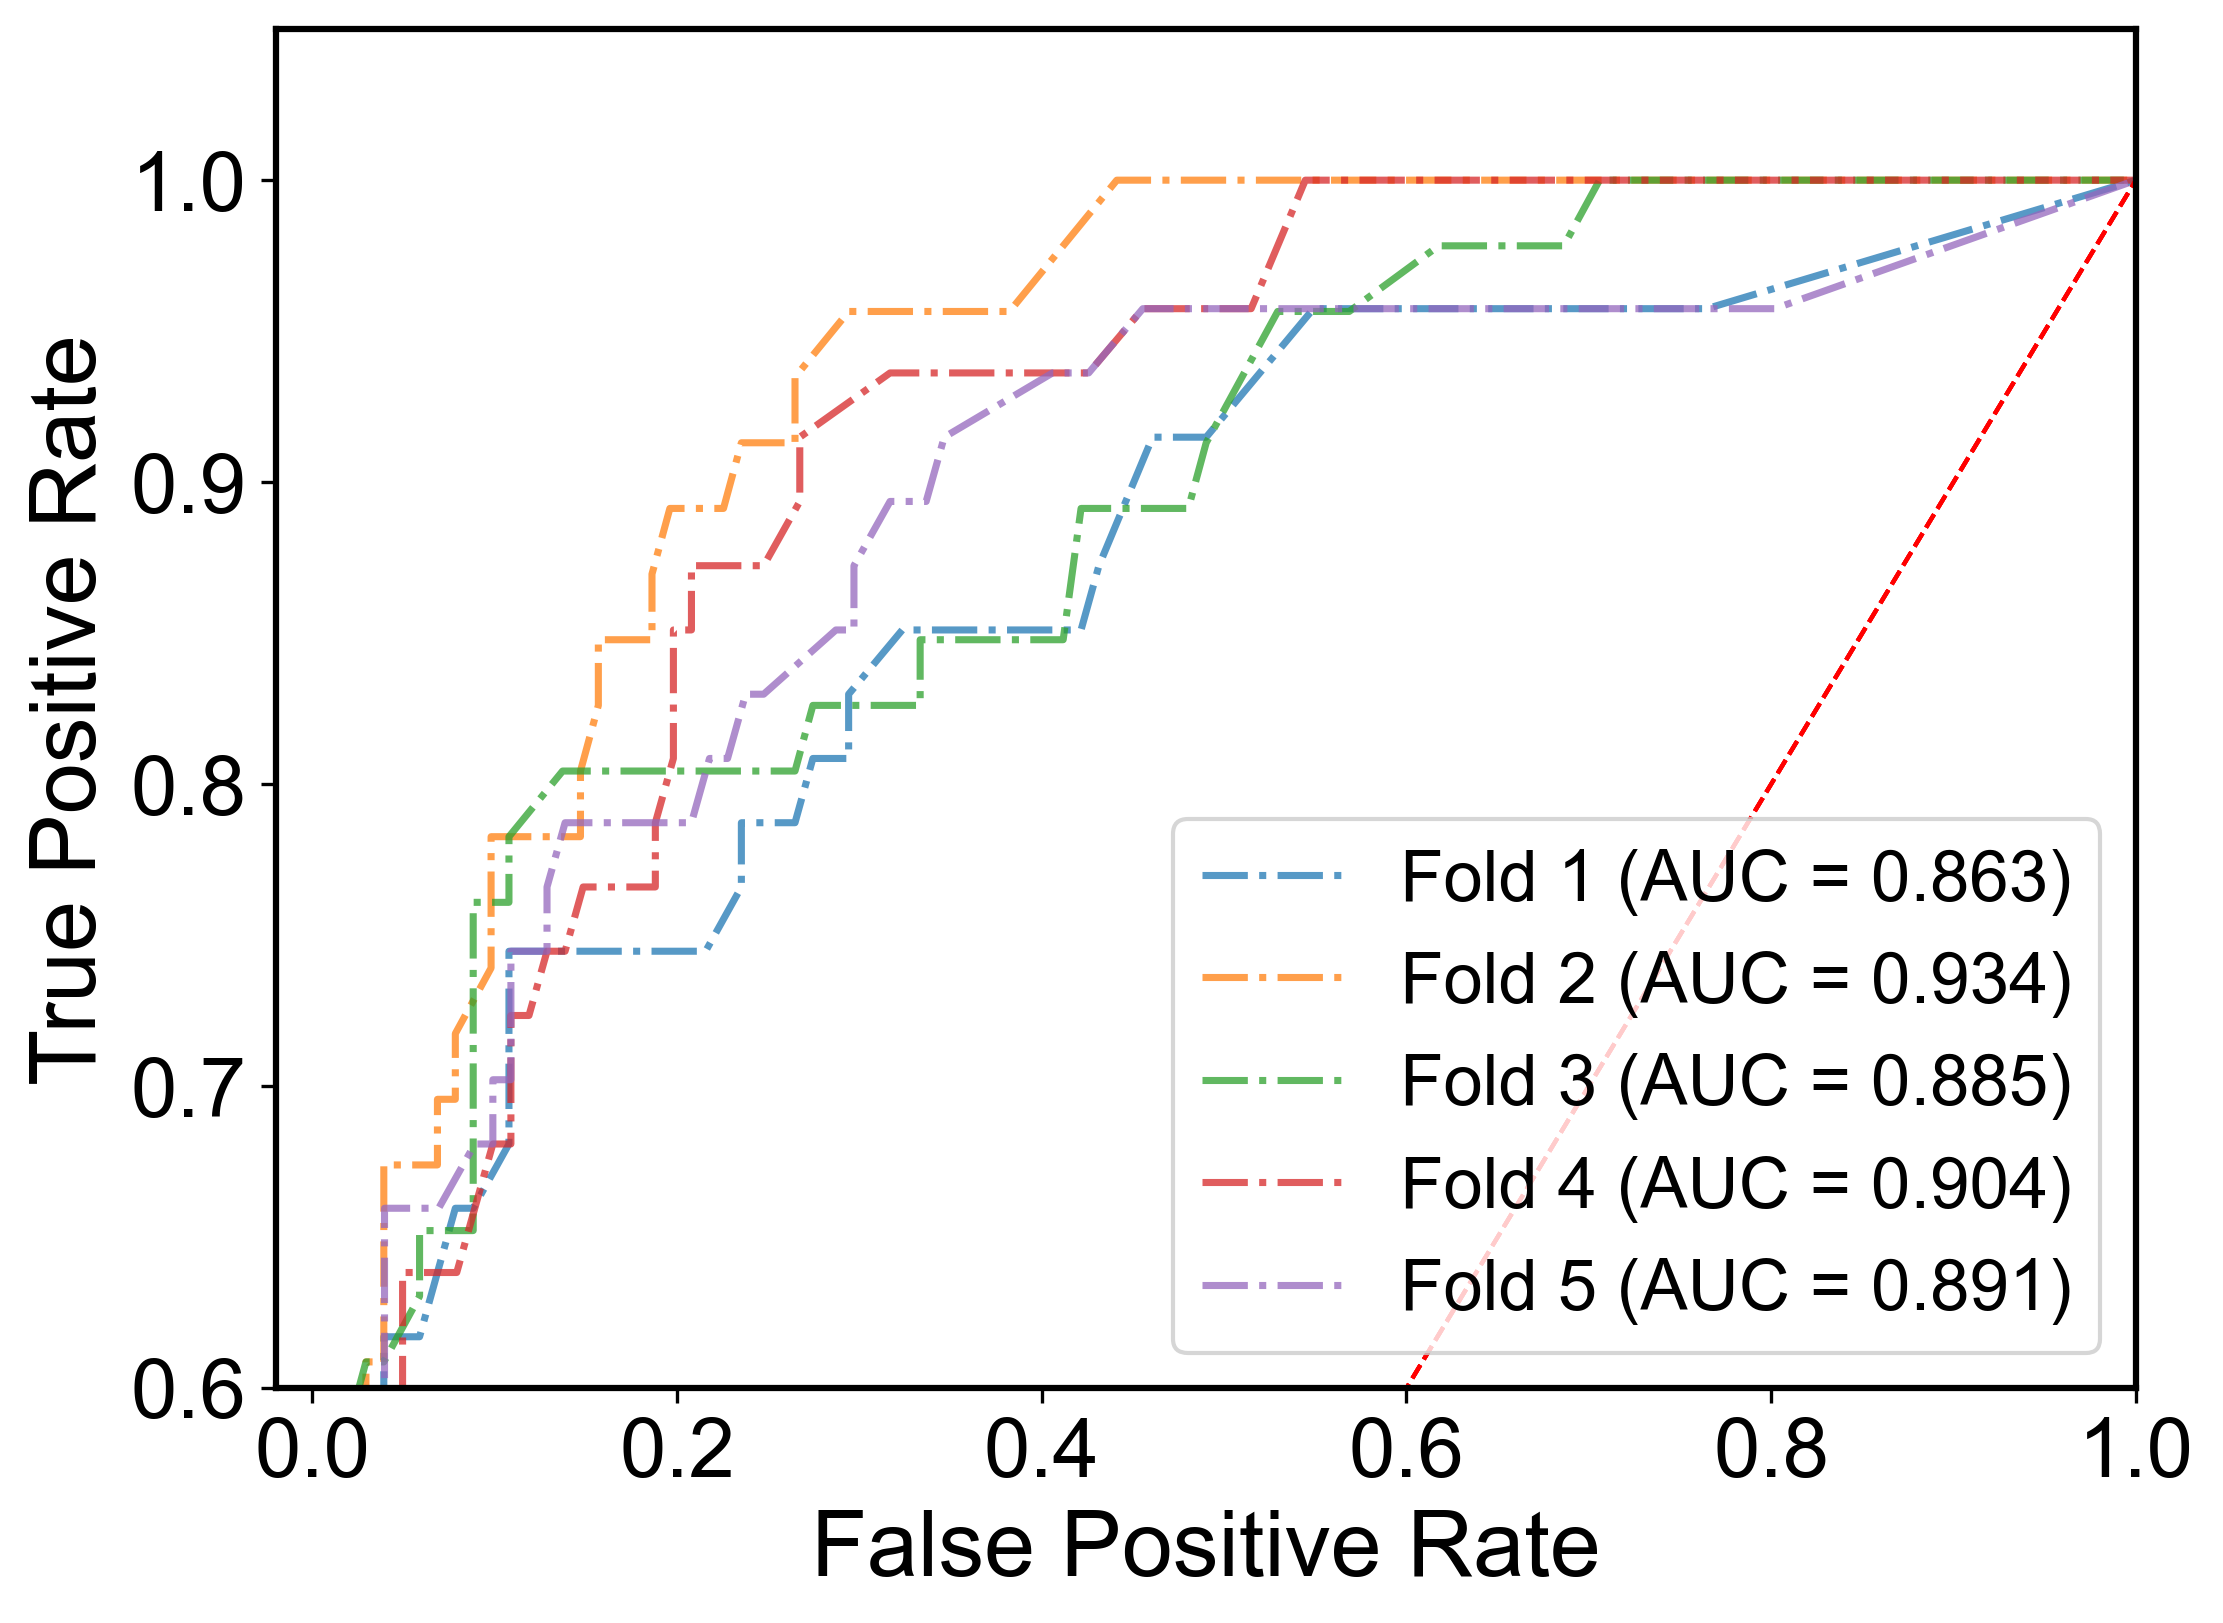

({'accuracy': 0.8434699800471612,
  'f1-score': 0.7387456271864068,
  'mcc': 0.6292165913562686,
  'roc_auc': 0.8956174950356764,
  'recall': 0.7039777983348751},
 [ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42)])

In [17]:
fold5(ext, X, y)

In [18]:
X_drop = X.drop(columns=['formation_energy_peratom'])

Fold 1 Accuracy: 0.8187919463087249 F1_Score: 0.6896551724137931  ROC_AUC: 0.8635794743429286
Fold 2 Accuracy: 0.8716216216216216 F1_Score: 0.7865168539325844  ROC_AUC: 0.9392583120204603
Fold 3 Accuracy: 0.8581081081081081 F1_Score: 0.7692307692307693  ROC_AUC: 0.8830988917306053
Fold 4 Accuracy: 0.8378378378378378 F1_Score: 0.7446808510638298  ROC_AUC: 0.9036233410575101
Fold 5 Accuracy: 0.831081081081081 F1_Score: 0.7252747252747254  ROC_AUC: 0.8796081735833158


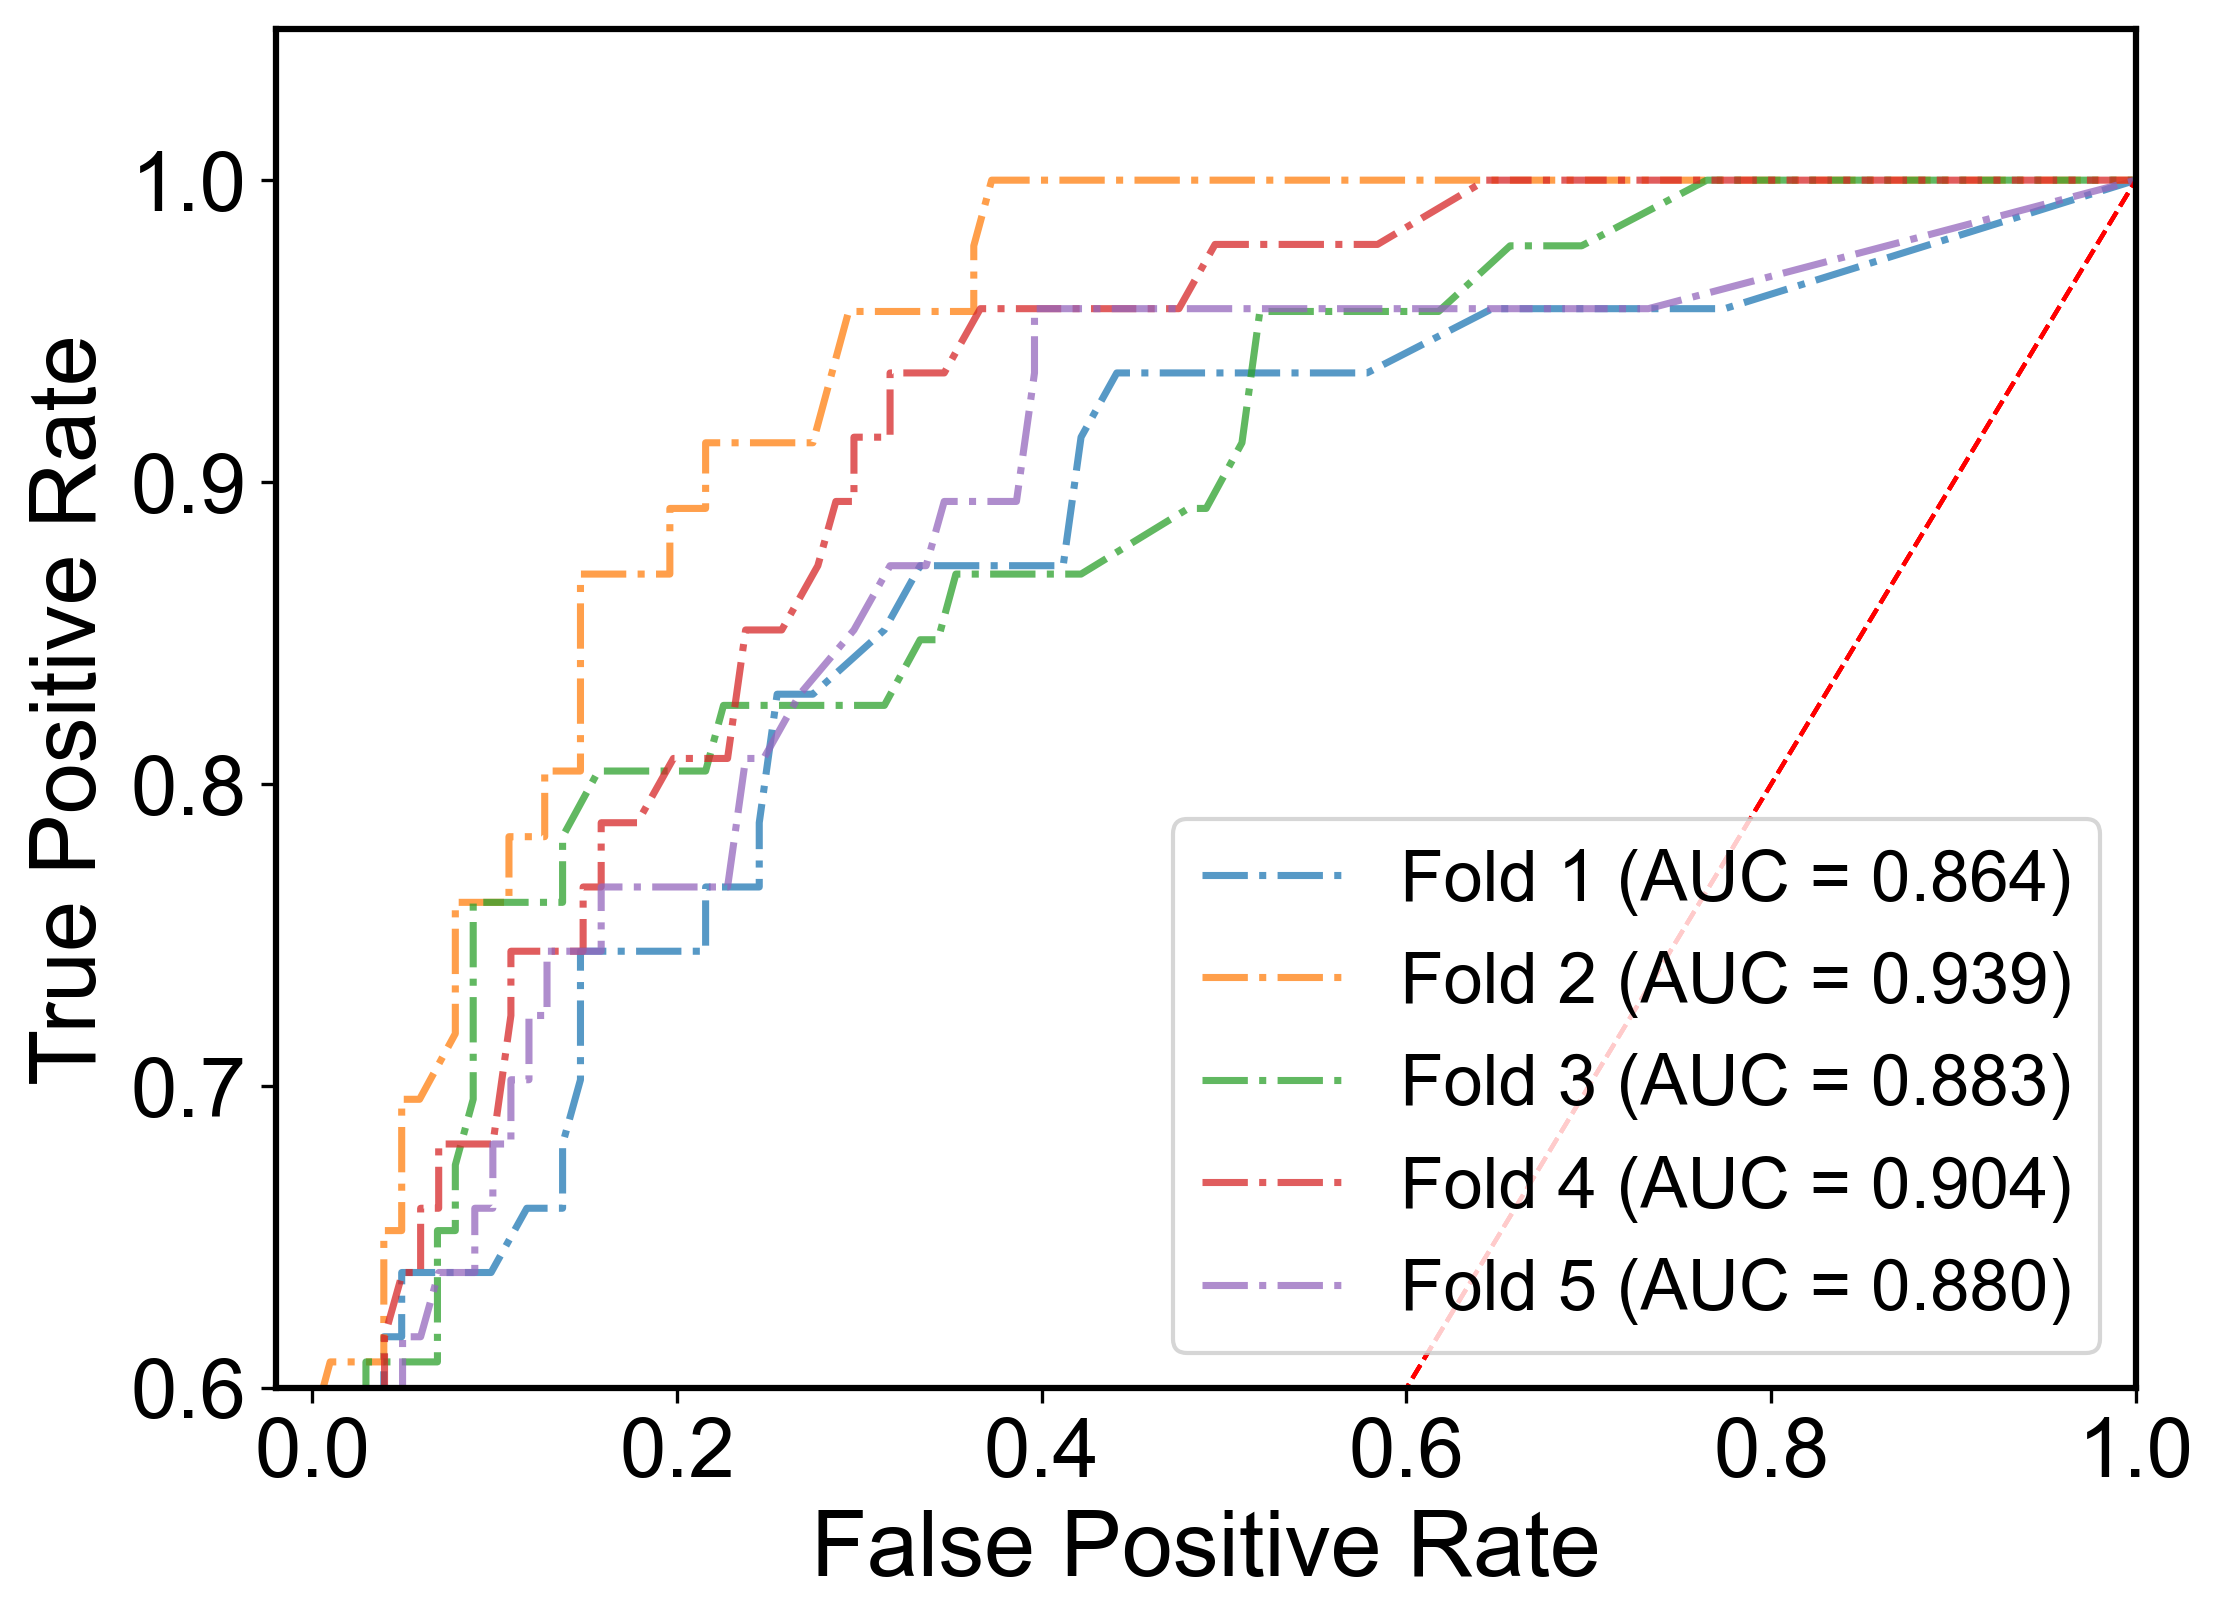

({'accuracy': 0.8434881189914746,
  'f1-score': 0.7430716743831404,
  'mcc': 0.6318315505600254,
  'roc_auc': 0.893833638546964,
  'recall': 0.7213691026827013},
 [ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42),
  ExtraTreesClassifier(n_jobs=-1, random_state=42)])

In [19]:
fold5(ext, X_drop, y)

In [294]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

def fold5_smote_ensemble_data(model, X, y, name='', is_plot=True):
    
    if hasattr(X, "columns"):
        feature_columns = X.columns.tolist()
    else:
        feature_columns = [f"feature_{i}" for i in range(X.shape[1])]
    label_column = "target"  
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models = []  
    accuracies = []
    f1s = []
    mccs = []
    roc_aucs = []
    recalls = []
    fig, ax = plt.subplots()
    
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        try:
            X_np = X.values if hasattr(X, "values") else X
            y_np = y.values if hasattr(y, "values") else y
        except:
            X_np = X
            y_np = y
        
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]
        
        # SMOTE
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

        train_df = pd.DataFrame(X_train_balanced, columns=feature_columns)
        train_df[label_column] = y_train_balanced
        train_df.to_csv(f"./data/ml_slme_data/slme_train[{i}].csv", index=False)
        y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=[label_column])
        y_train_balanced_df.to_csv(f"./data/ml_slme_data/y_train_balanced[{i}].csv", index=False)
        test_df = pd.DataFrame(X_test, columns=feature_columns)
        test_df[label_column] = y_test
        test_df.to_csv(f"./data/ml_slme_data/ml_slme_slme_test[{i}].csv", index=False)
        
        print(f"Fold {i+1}:")
        print(f"Original class distribution: {dict(Counter(y_train))}")
        print(f"SMOTE class distribution: {dict(Counter(y_train_balanced))}\n")
        
        model.fit(X_train_balanced, y_train_balanced)
        models.append(model)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        df_prob = pd.DataFrame({
            'true_label': y_test,
            'pred_label': y_pred,
            'predict_proba': [f"{p:.2f}" for p in y_prob]  
        })

        df_prob.to_csv(f'./data/ml_slme_data/fold{i}_predict_prob.csv', index=False)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        mcc = metrics.matthews_corrcoef(y_test, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        recall = metrics.recall_score(y_test, y_pred)
        
        print(f"Fold {i+1} Accuracy: {accuracy} F1_Score: {f1}  ROC_AUC: {roc_auc}")
        
        accuracies.append(accuracy)
        f1s.append(f1)
        mccs.append(mcc)
        roc_aucs.append(roc_auc)
        recalls.append(recall)
        
        if is_plot
            ax.plot(fpr, tpr, label=f"Fold {i+1} (AUC = {roc_auc:.3f})", lw=1.7, linestyle="-.", alpha=0.75)
            ax.plot([0, 1], [0, 1], "r--", lw=1, alpha=0.8)
            ax.set_xlim([-0.02, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel("False Positive Rate", fontsize=22)
            ax.set_ylabel("True Positive Rate", fontsize=22)
           # ax.set_title(f"ROC Curves: {name}", fontweight="bold")
            ax.legend(loc="lower right" ,fontsize=17)
            ax.grid(True, linestyle="--", linewidth=1, alpha=0.5)
            ax.spines["top"].set_linewidth(1.5)
            ax.spines["bottom"].set_linewidth(1.5)
            ax.spines["left"].set_linewidth(1.5)
            ax.spines["right"].set_linewidth(1.5)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.grid(False)           
    result = {
        "accuracy": np.mean(accuracies),
        "f1-score": np.mean(f1s),
        "mcc": np.mean(mccs),
        "roc_auc": np.mean(roc_aucs),
        "recall": np.mean(recalls)
    }
    
    if is_plot:
        #plt.savefig("./picture/slme_smote.png", dpi=300, bbox_inches="tight")
        plt.show()
    
    return result, models

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

Fold 1 Accuracy: 0.7114093959731543 F1_Score: 0.49411764705882355  ROC_AUC: 0.6400709219858156
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 2 Accuracy: 0.7635135135135135 F1_Score: 0.6601941747572816  ROC_AUC: 0.7568201193520887
Fold 3:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 3 Accuracy: 0.7635135135135135 F1_Score: 0.6534653465346534  ROC_AUC: 0.7508525149190111
Fold 4:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 4 Accuracy: 0.7905405405405406 F1_Score: 0.6930693069306931  ROC_AUC: 0.7782810195913209
Fold 5:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 5 Accuracy: 0.8108108108108109 F1_Score: 0.7358490566037736  ROC_AUC: 0.8158837160311776


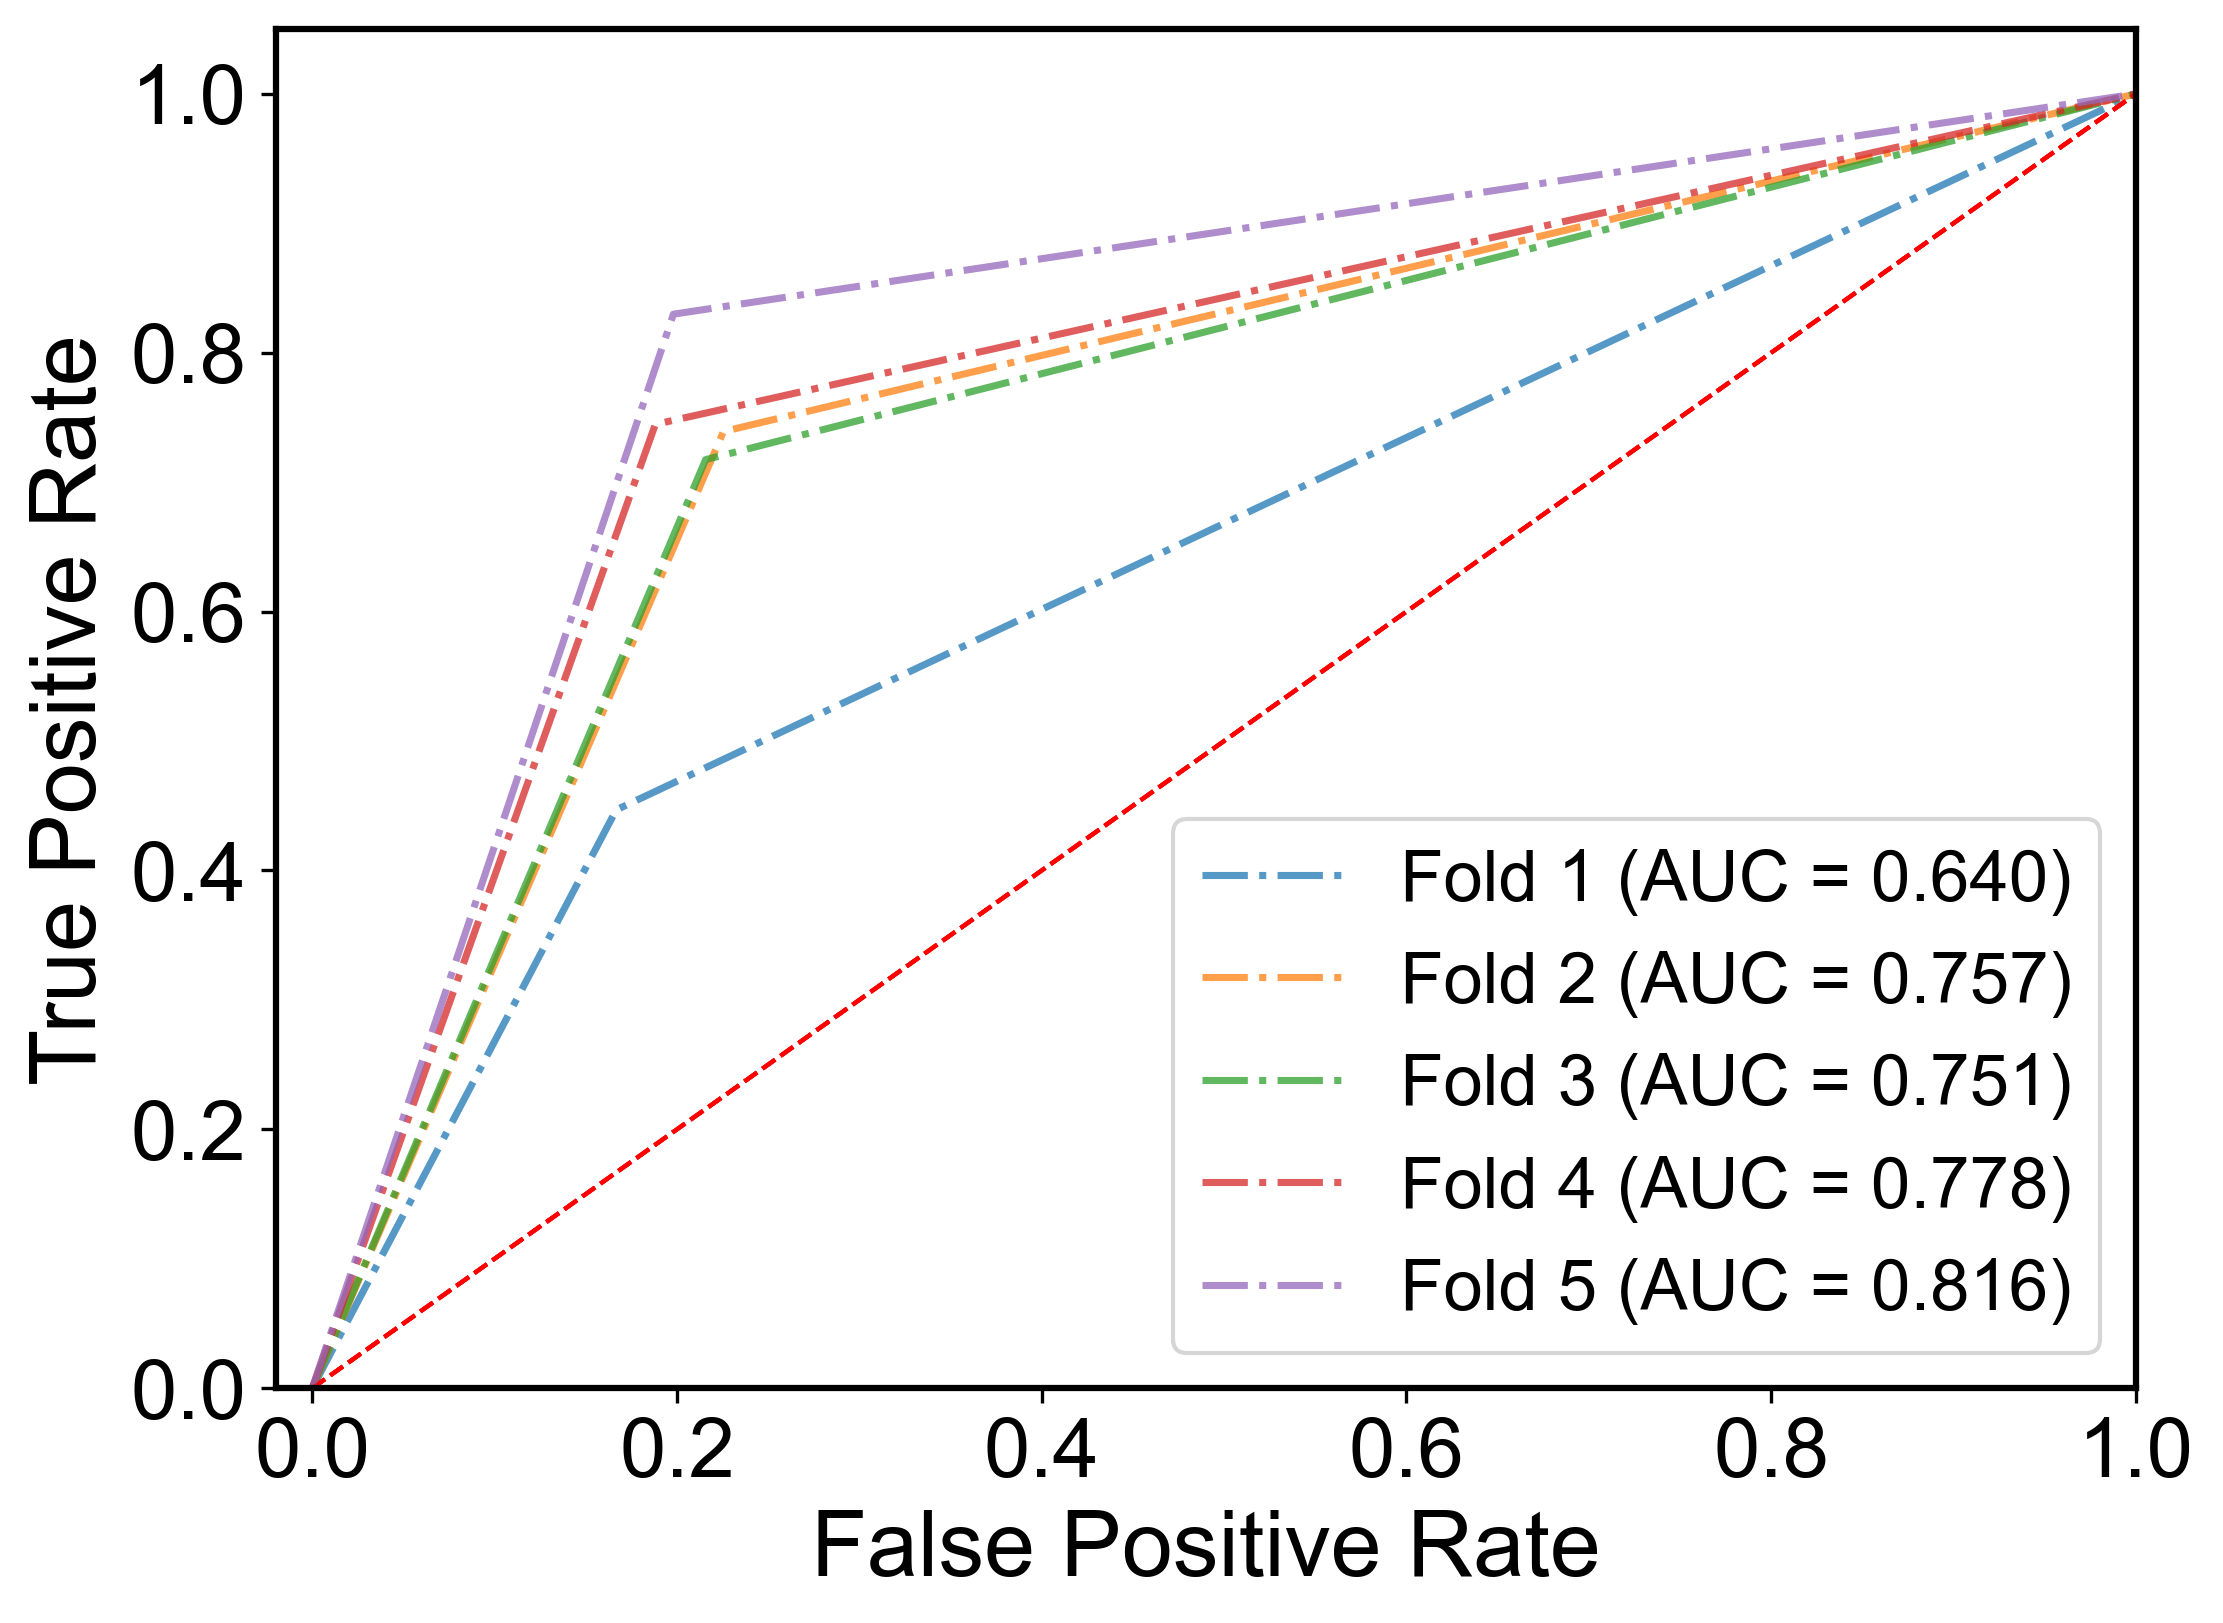

{'accuracy': 0.7679575548703066,
 'f1-score': 0.6473391063770451,
 'mcc': 0.4813188530458441,
 'roc_auc': 0.7483816583758827,
 'recall': 0.6955596669750232}

In [235]:
dt_result, dt_models = fold5_smote_ensemble_data(dt, X, y)
dt_result

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

Fold 1 Accuracy: 0.825503355704698 F1_Score: 0.7045454545454545  ROC_AUC: 0.8581560283687943
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 2 Accuracy: 0.8513513513513513 F1_Score: 0.75  ROC_AUC: 0.940537084398977
Fold 3:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 3 Accuracy: 0.8175675675675675 F1_Score: 0.6966292134831461  ROC_AUC: 0.869458653026428
Fold 4:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 4 Accuracy: 0.8243243243243243 F1_Score: 0.7173913043478262  ROC_AUC: 0.881082789129977
Fold 5:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 5 Accuracy: 0.8175675675675675 F1_Score: 0.7096774193548387  ROC_AUC: 0.8848746576785338


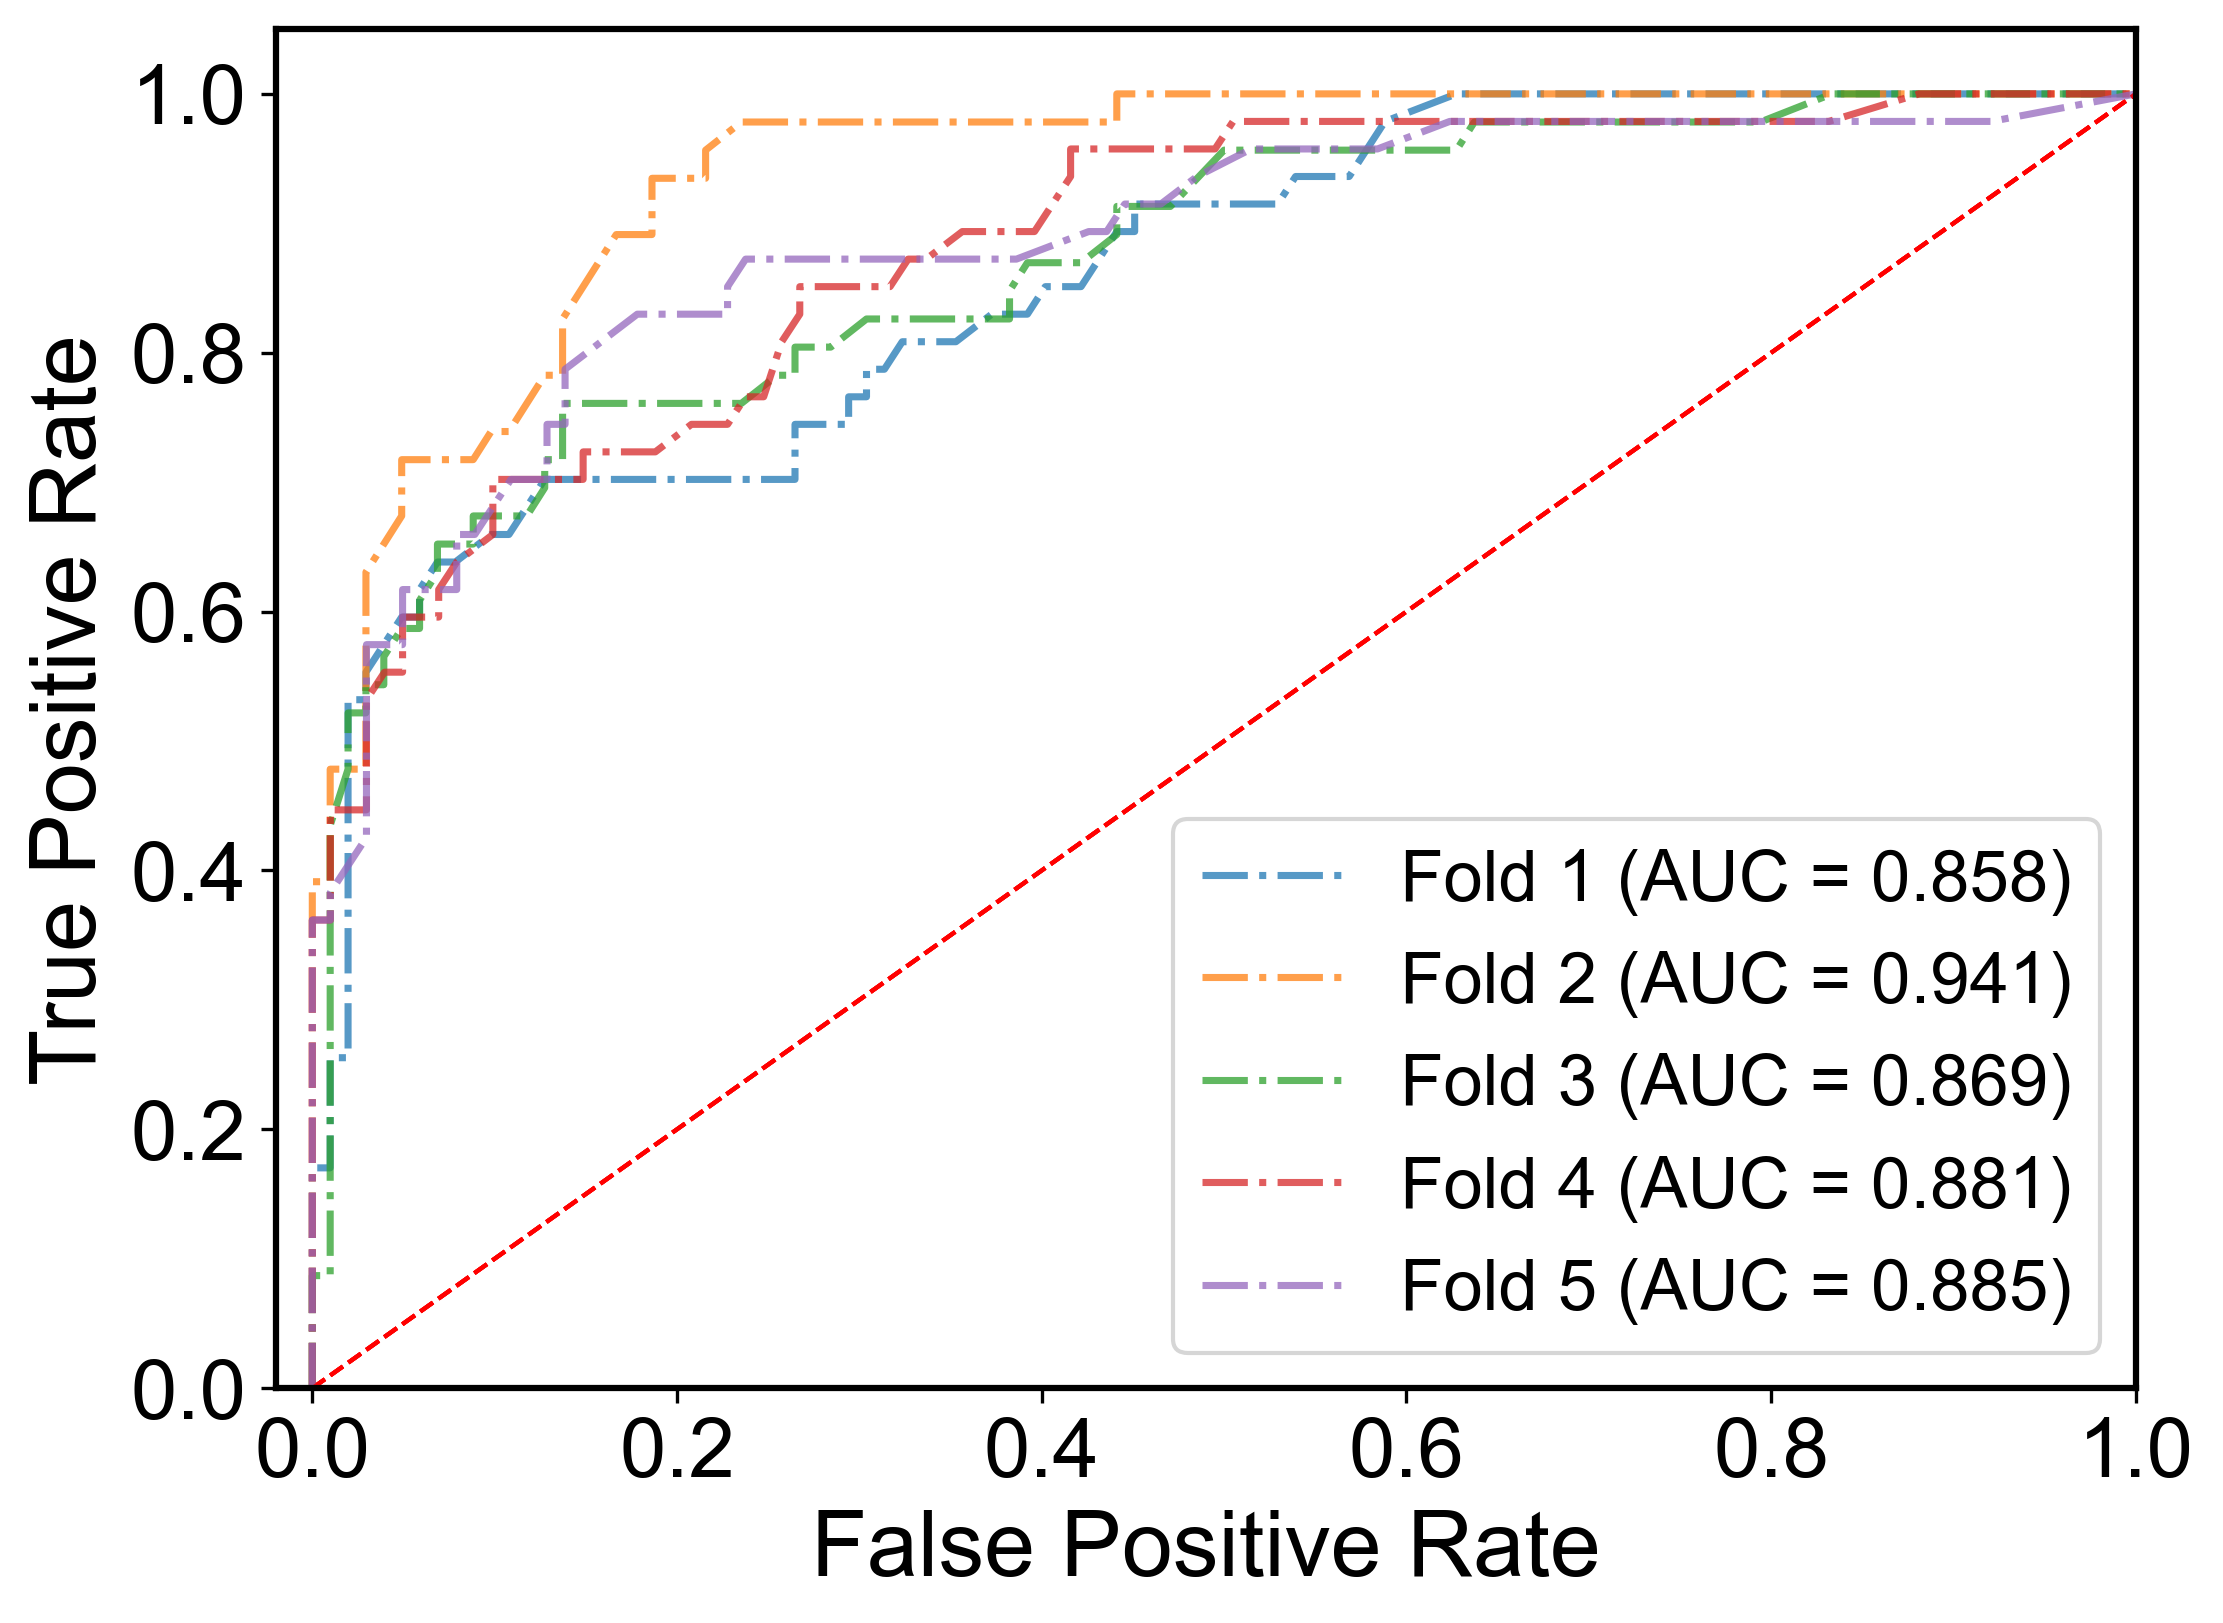

{'accuracy': 0.8272628333031017,
 'f1-score': 0.7156486783462531,
 'mcc': 0.5928650567486146,
 'roc_auc': 0.886821842520542,
 'recall': 0.6910268270120259}

In [236]:
rf_result, rf_models = fold5_smote_ensemble_data(rf, X, y)
rf_result

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

Fold 1 Accuracy: 0.6711409395973155 F1_Score: 0.5504587155963303  ROC_AUC: 0.7190237797246558
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 2 Accuracy: 0.722972972972973 F1_Score: 0.6306306306306305  ROC_AUC: 0.7859121909633419
Fold 3:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 3 Accuracy: 0.668918918918919 F1_Score: 0.5242718446601942  ROC_AUC: 0.704923273657289
Fold 4:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 4 Accuracy: 0.6756756756756757 F1_Score: 0.5789473684210525  ROC_AUC: 0.7369917842848115
Fold 5:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 5 Accuracy: 0.668918918918919 F1_Score: 0.5504587155963303  ROC_AUC: 0.7359384874657678


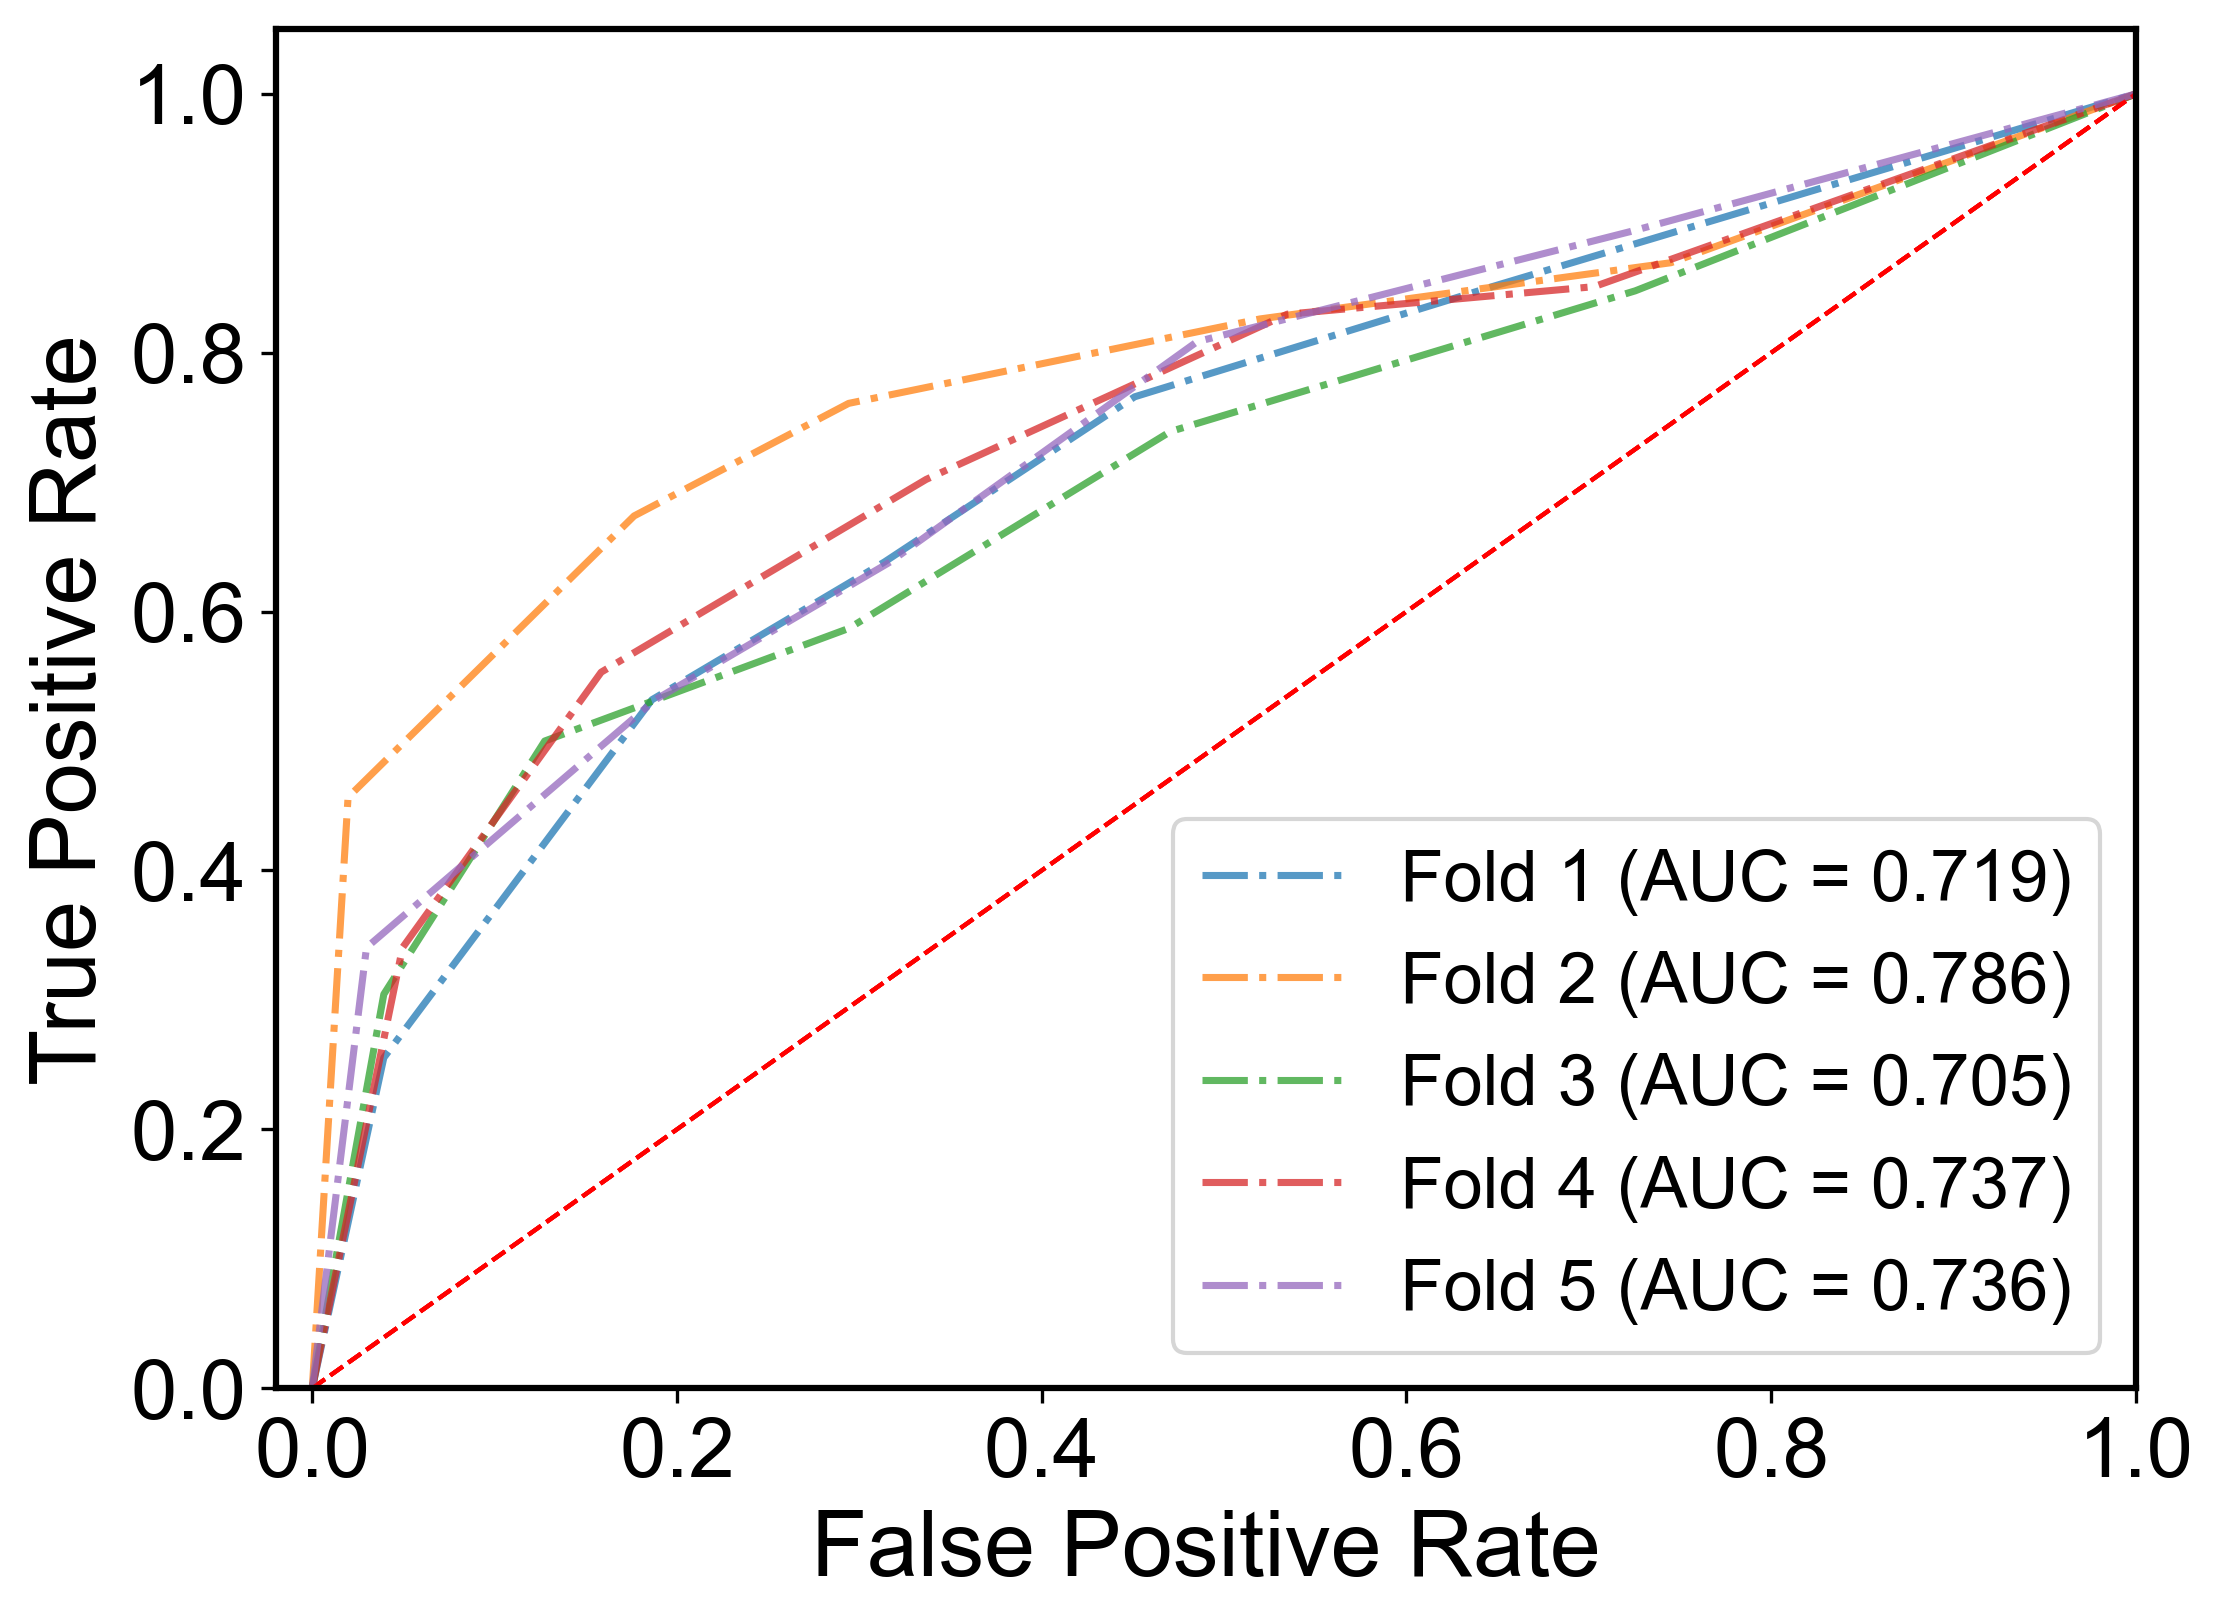

{'accuracy': 0.6815254852167605,
 'f1-score': 0.5669534549809075,
 'mcc': 0.33298676355000606,
 'roc_auc': 0.7365579032191732,
 'recall': 0.6653098982423682}

In [237]:
kn_result, kn_models = fold5_smote_ensemble_data(kn, X, y)
kn_result

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

Fold 1 Accuracy: 0.7046979865771812 F1_Score: 0.18518518518518517  ROC_AUC: 0.7104714226115979
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 2 Accuracy: 0.6756756756756757 F1_Score: 0.5932203389830508  ROC_AUC: 0.7691815856777493
Fold 3:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 3 Accuracy: 0.5608108108108109 F1_Score: 0.49612403100775204  ROC_AUC: 0.6986359761295823
Fold 4:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 4 Accuracy: 0.6959459459459459 F1_Score: 0.3283582089552239  ROC_AUC: 0.7036022751211292
Fold 5:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 5 Accuracy: 0.38513513513513514 F1_Score: 0.48000000000000004  ROC_AUC: 0.625026332420476


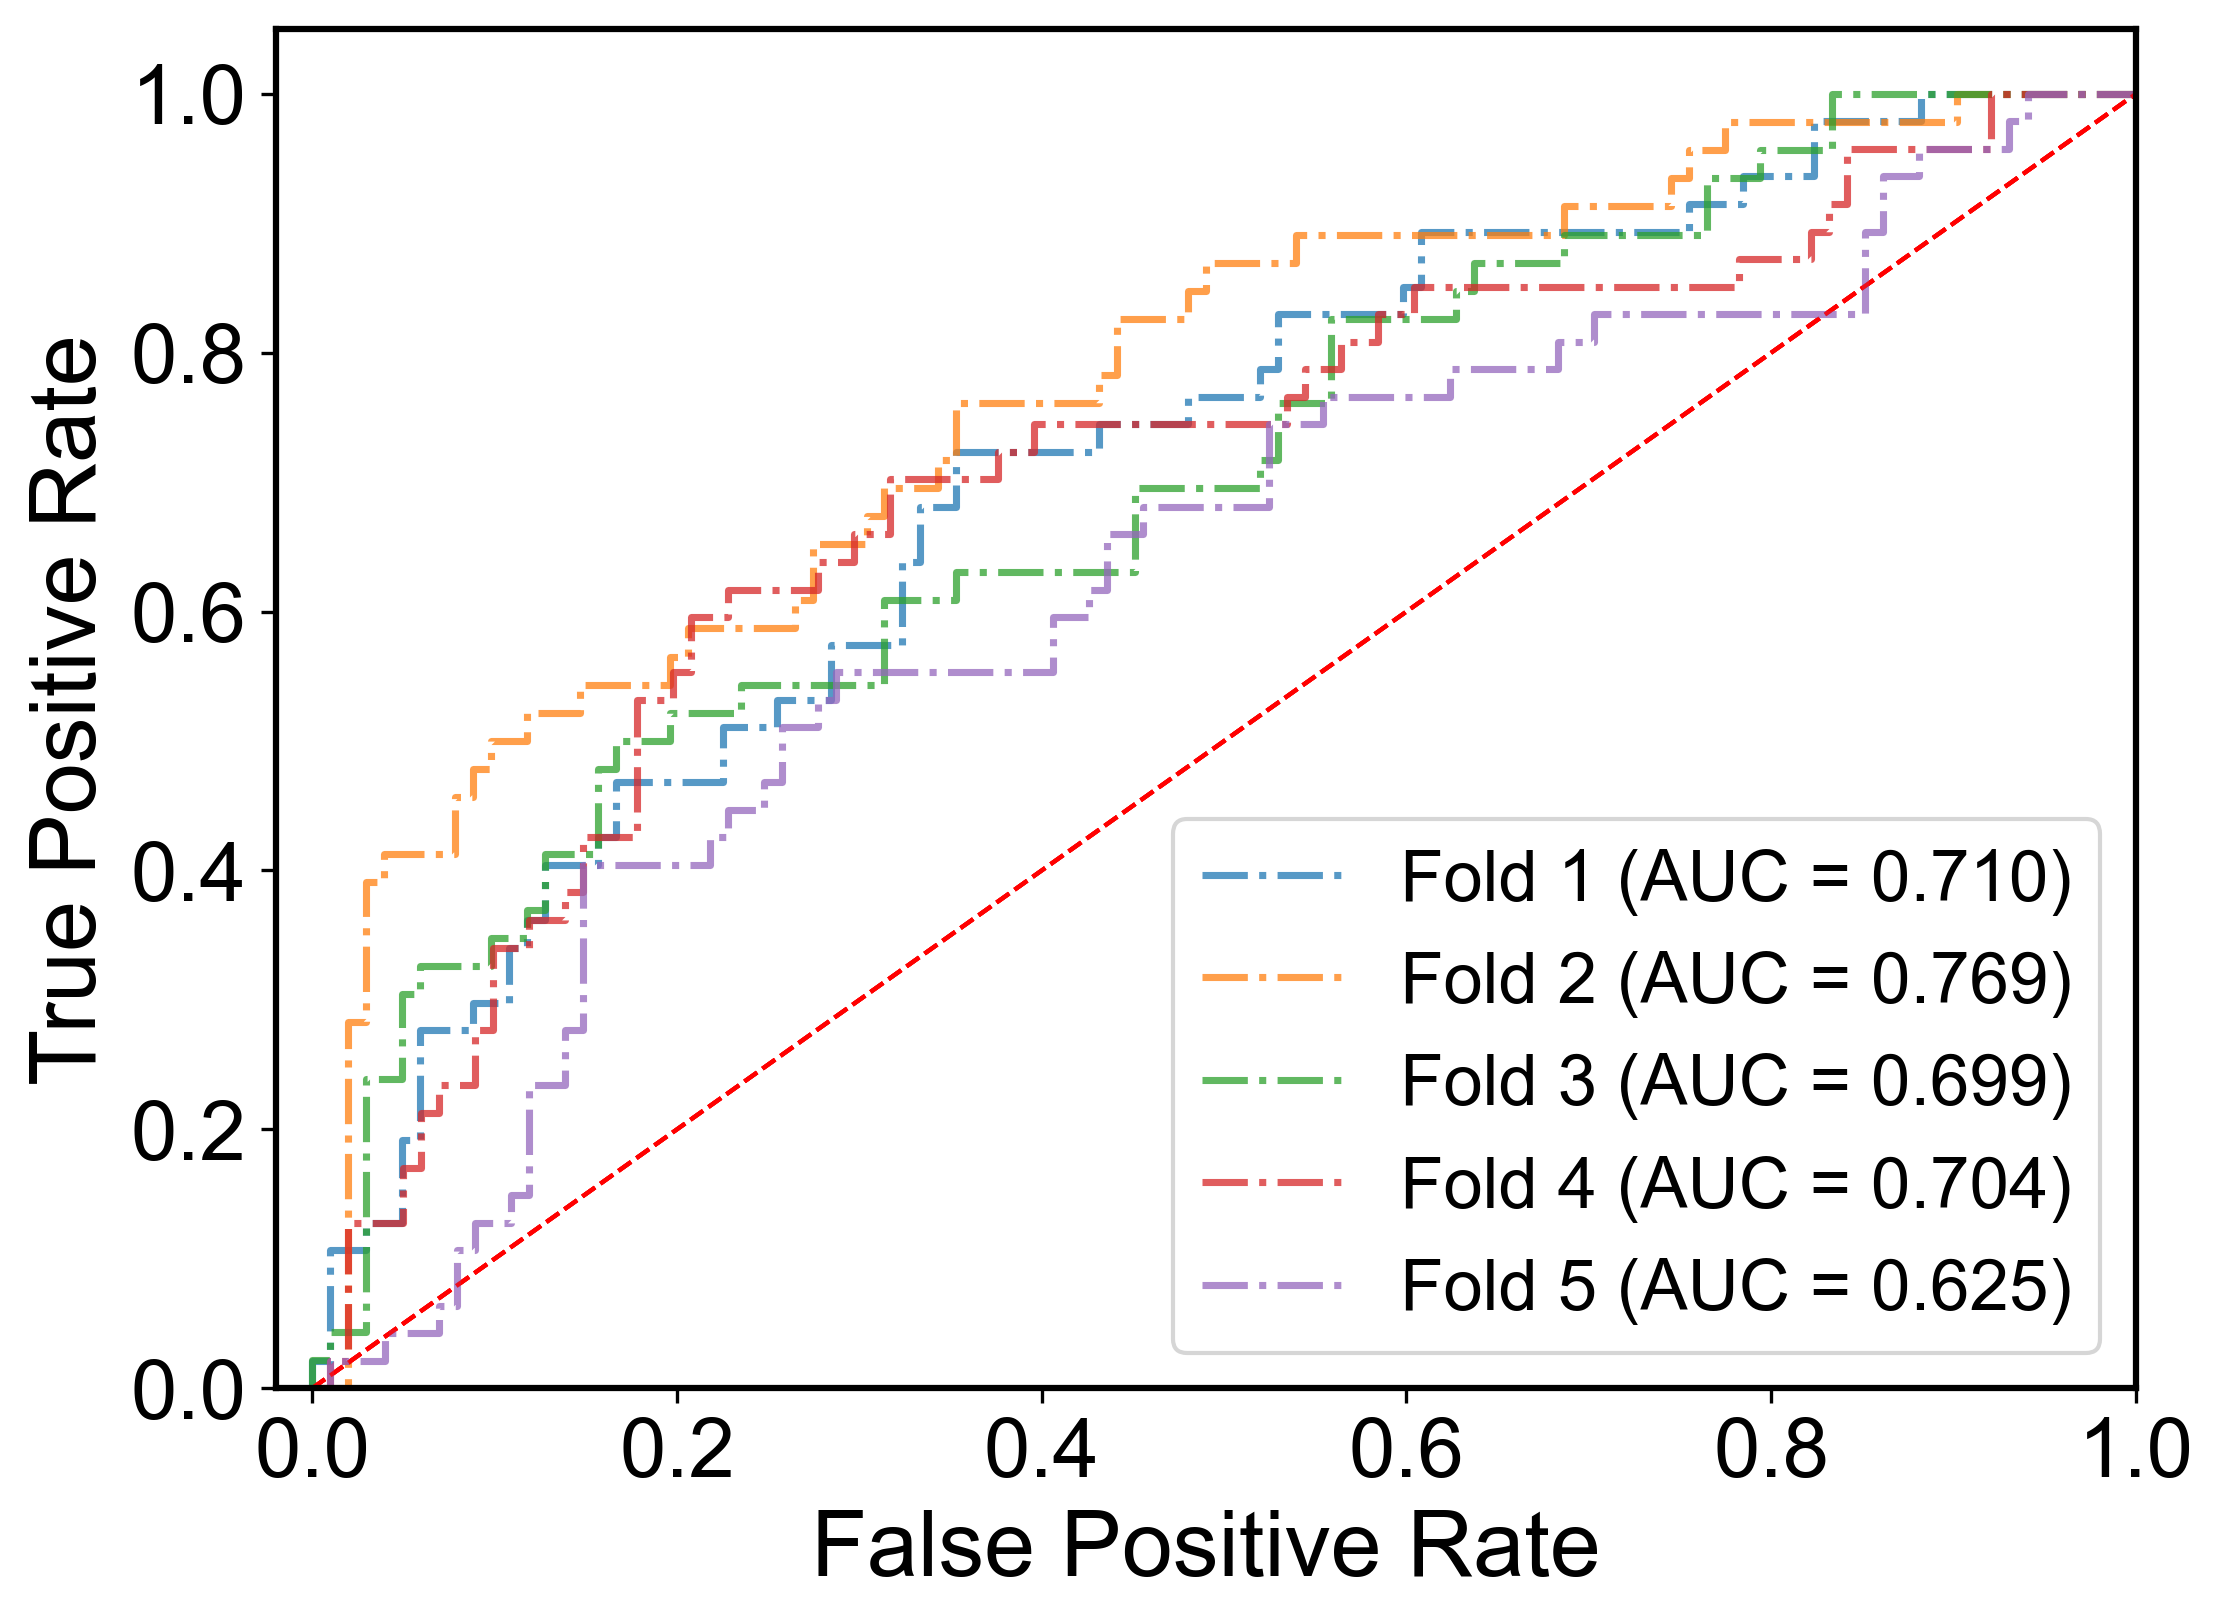

{'accuracy': 0.6044531108289497,
 'f1-score': 0.4165775528262424,
 'mcc': 0.19928390586574588,
 'roc_auc': 0.701383518392107,
 'recall': 0.5381128584643848}

In [238]:
mlp_result, mlp_models = fold5_smote_ensemble_data(mlp, X, y)
mlp_result

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

Fold 1 Accuracy: 0.7919463087248322 F1_Score: 0.651685393258427  ROC_AUC: 0.8410513141426783
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 2 Accuracy: 0.8445945945945946 F1_Score: 0.7415730337078652  ROC_AUC: 0.9111253196930946
Fold 3:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 3 Accuracy: 0.7972972972972973 F1_Score: 0.6875  ROC_AUC: 0.8422847399829497
Fold 4:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 4 Accuracy: 0.7905405405405406 F1_Score: 0.6804123711340208  ROC_AUC: 0.872972403623341
Fold 5:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 5 Accuracy: 0.8581081081081081 F1_Score: 0.7692307692307692  ROC_AUC: 0.8950916368232569


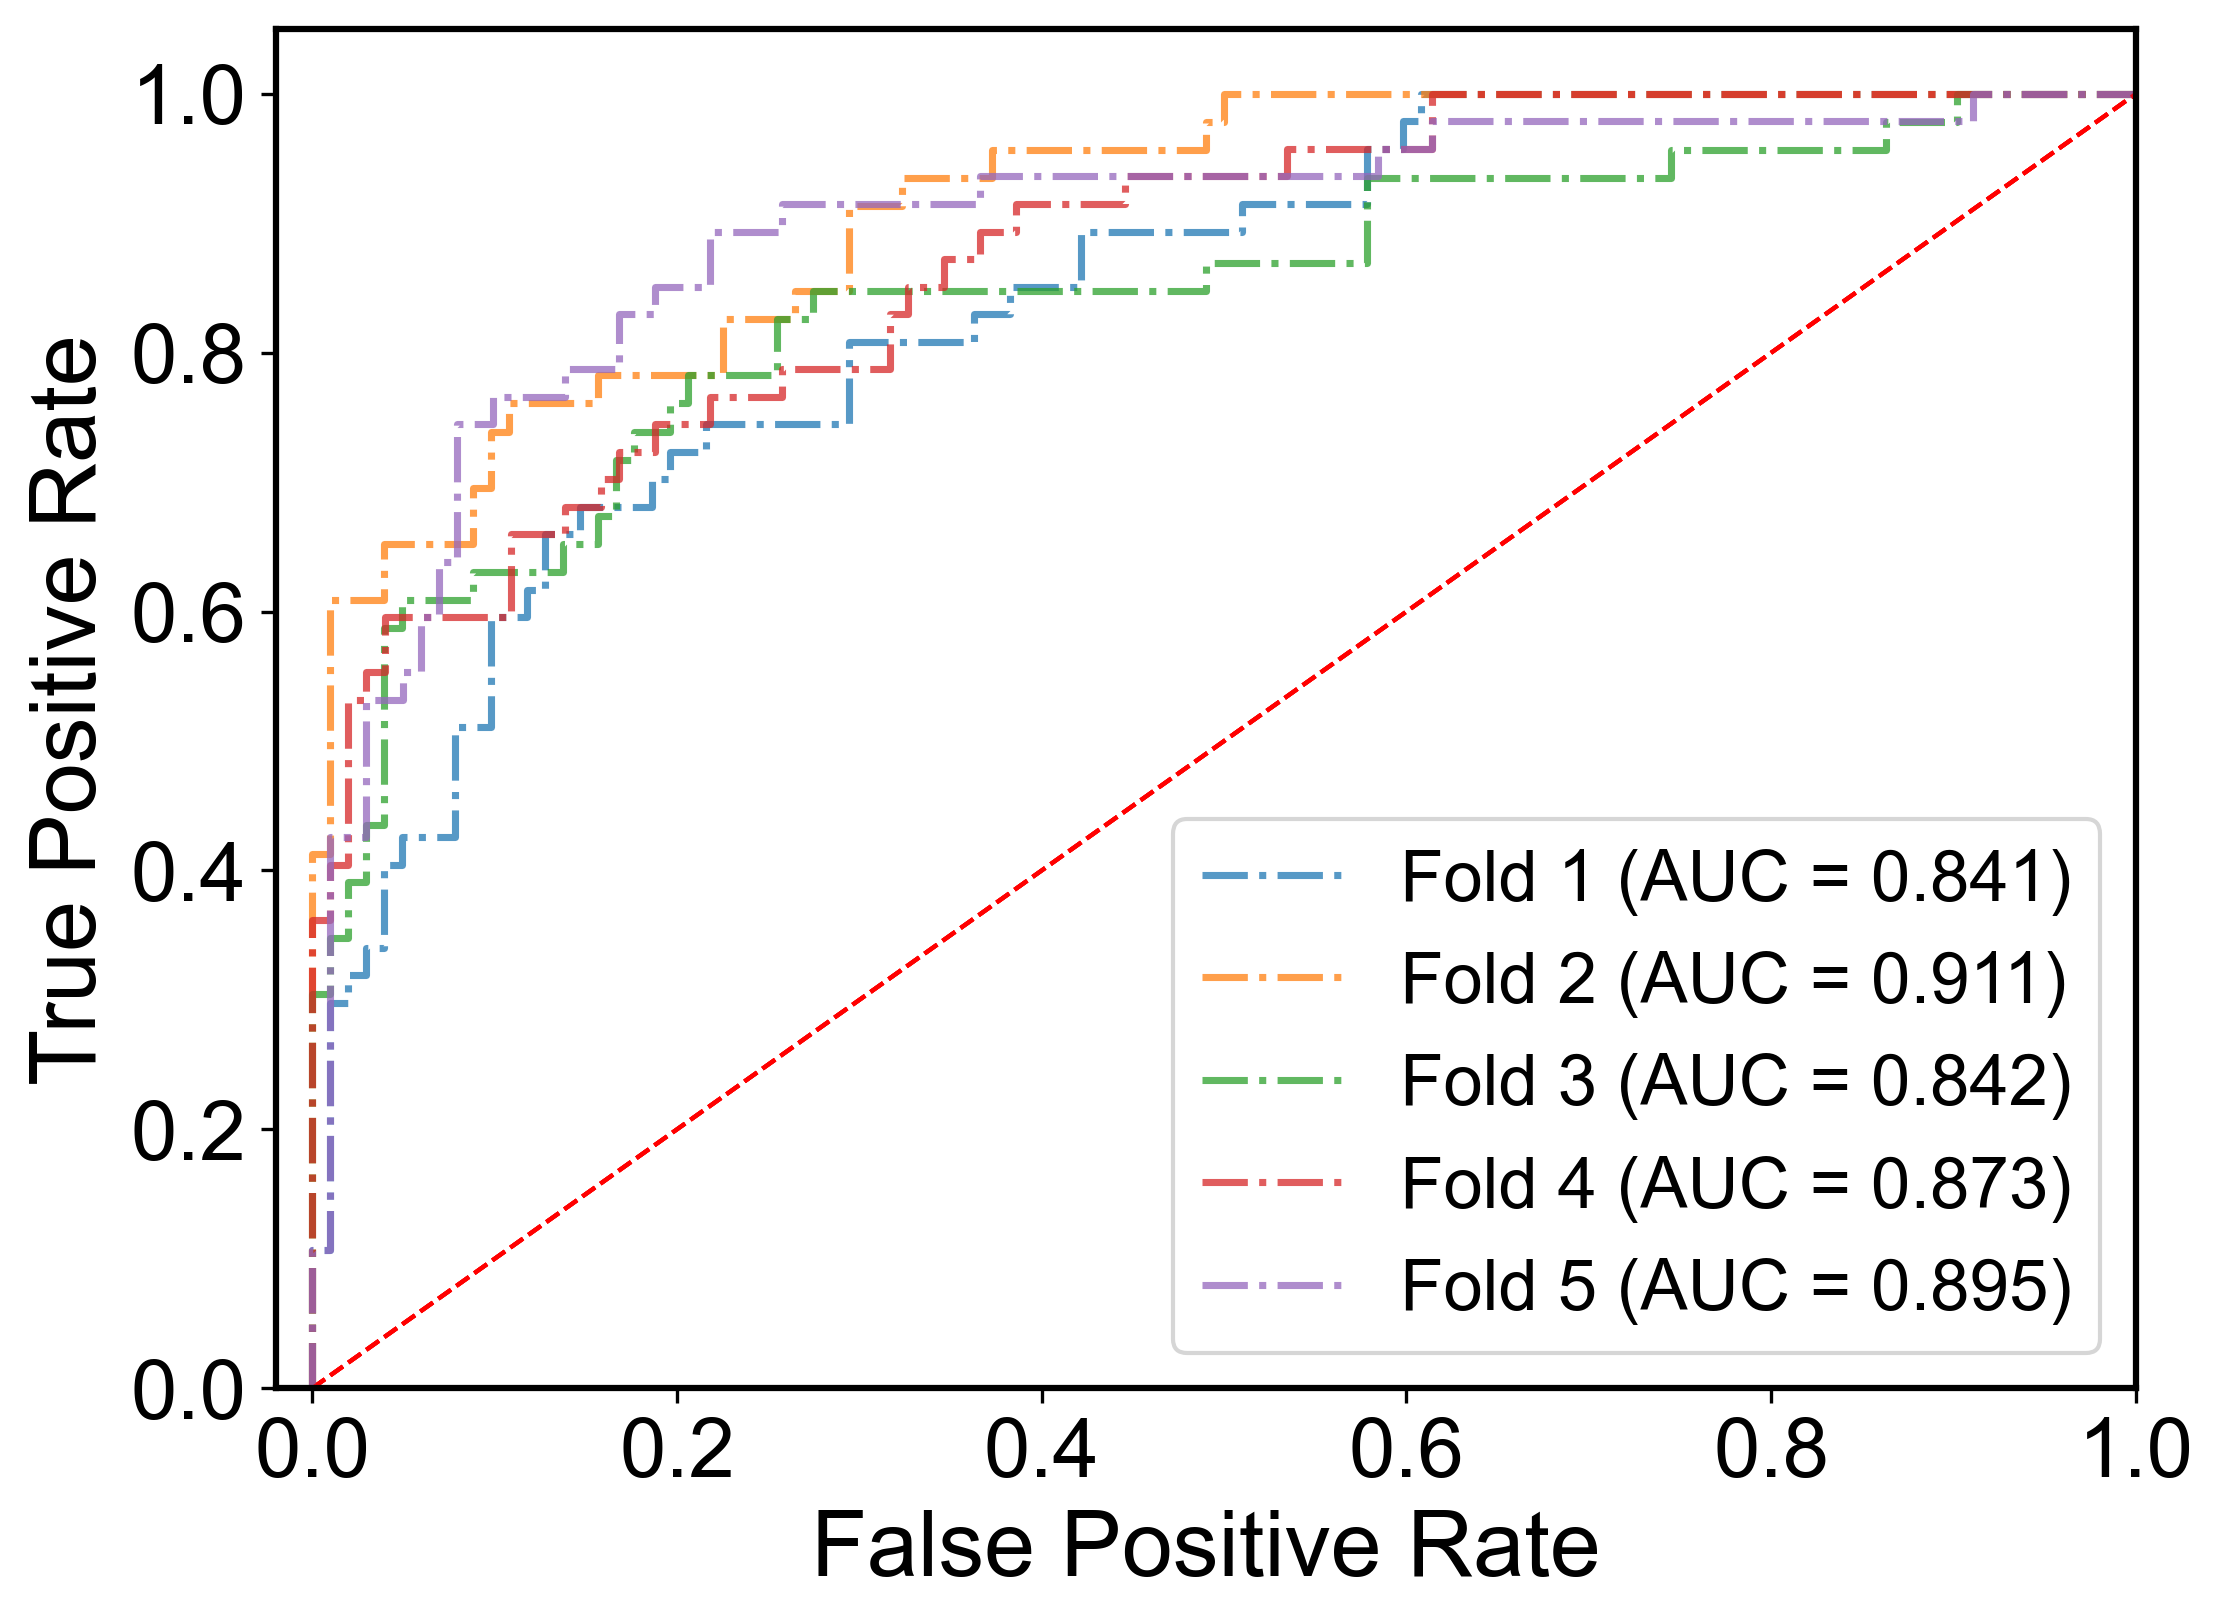

{'accuracy': 0.8164973698530746,
 'f1-score': 0.7060803134662164,
 'mcc': 0.5738102023720922,
 'roc_auc': 0.872505082853064,
 'recall': 0.699722479185939}

In [241]:
xgb_result, xgb_models = fold5_smote_ensemble_data(xb, X, y)
xgb_result

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1 Accuracy: 0.825503355704698 F1_Score: 0.711111111111111  ROC_AUC: 0.8781810596579057
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2 Accuracy: 0.8445945945945946 F1_Score: 0.7526881720430109  ROC_AUC: 0.930306905370844
Fold 3:
Original cl

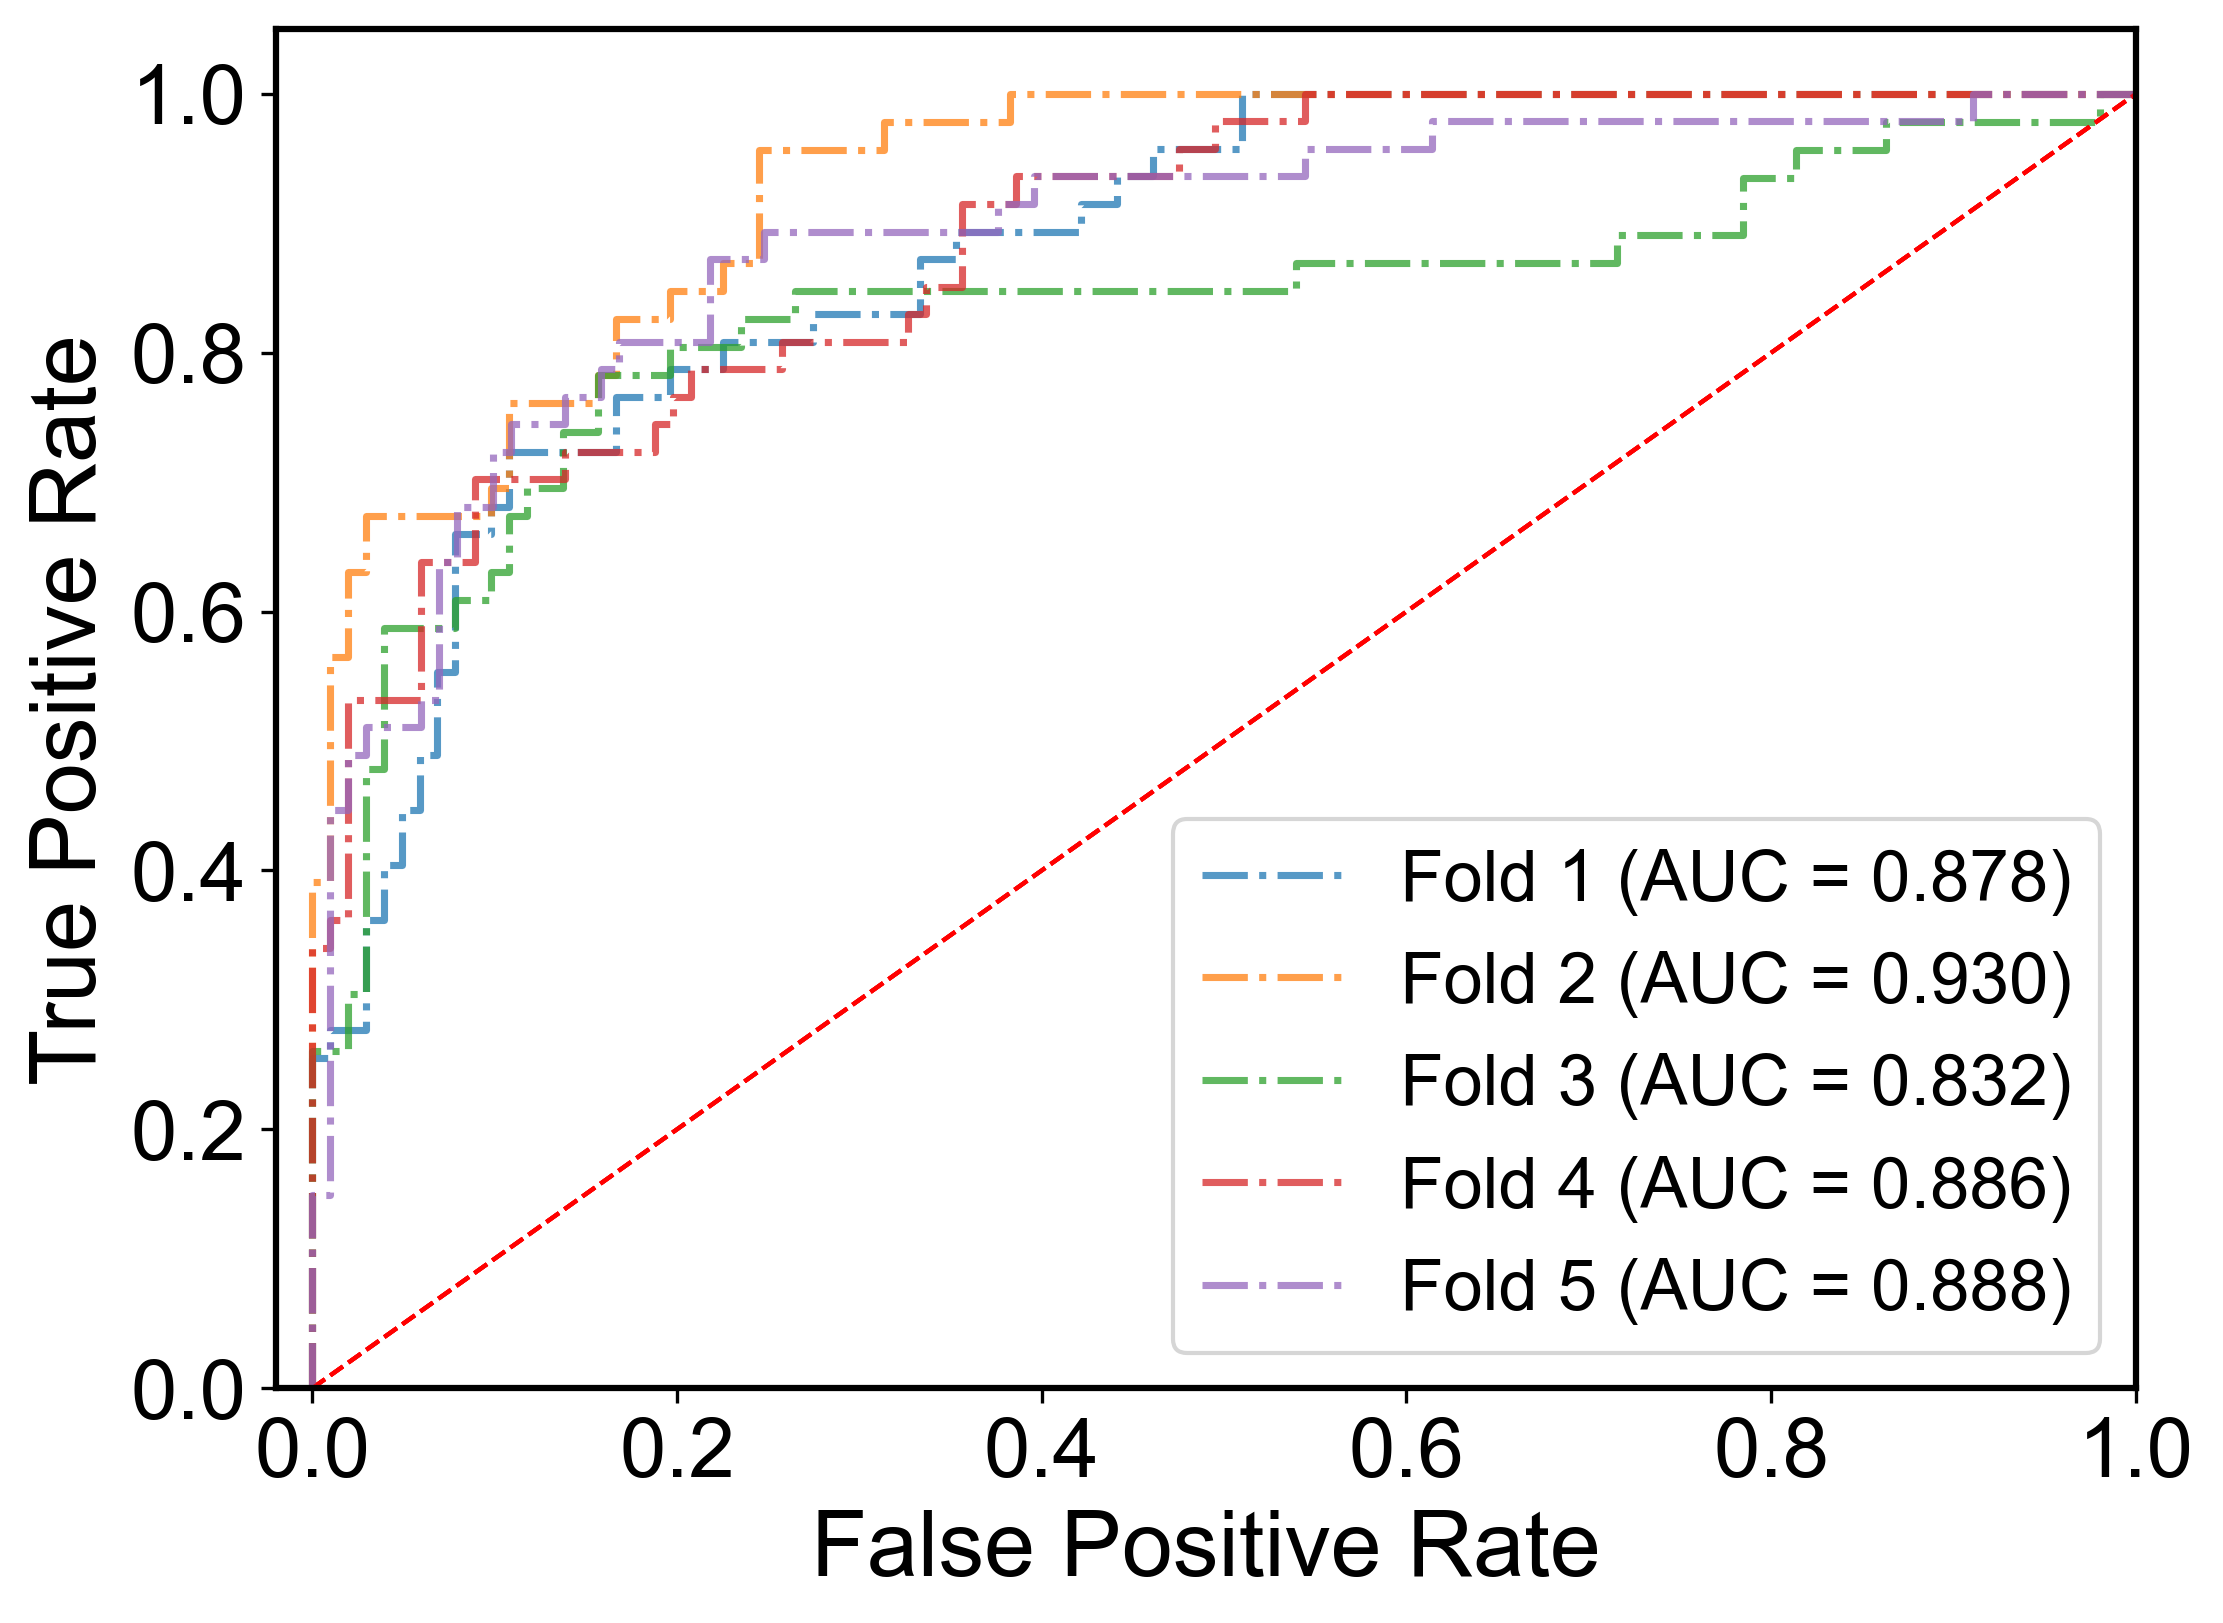

{'accuracy': 0.8286141846544531,
 'f1-score': 0.7291838184876489,
 'mcc': 0.6045591994268762,
 'roc_auc': 0.8827314904859371,
 'recall': 0.7341350601295097}

In [239]:
lgbm_result, lgbm_models = fold5_smote_ensemble_data(lgbm, X, y)
lgbm_result

In [20]:
df1 = pd.concat([X,y], axis=1)

In [21]:
from joblib import Parallel, delayed
from time import time
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

def init_population(n, c):
    return np.array([[math.ceil(e) for e in pop] for pop in (np.random.rand(n, c) - 0.5)]), np.zeros((2, c)) - 1

def single_point_crossover(population):
    r, c = population.shape
    n = np.random.randint(1, c)         
    for i in range(0, r, 2):                
        population[i], population[i+1] = np.append(population[i][0:n], population[i+1][n:c]), np.append(population[i+1][0:n], population[i][n:c])        
    return population

def flip_mutation(population):
    return population.max() - population

def random_selection(population):
    r = population.shape[0]
    new_population = population.copy()    
    for i in range(r):        
        new_population[i] = population[np.random.randint(0, r)]
    return new_population

def predictive_model_cv(X, y, model, selected_features):

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    #5-fold CV
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index][selected_features], X.iloc[test_index][selected_features]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # SMOTE
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        mdl = model
        mdl.fit(X_train_balanced, y_train_balanced)
        y_pred = mdl.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    # Return the average score of cross-validation
    return np.mean(scores)

def individual_fitness_cv(individual, data, feature_list, target, model):
    # Based on individual selection characteristics
    selected_features = [feature_list[j] for j in range(individual.shape[0]) if individual[j] == 1] 
    # Evaluate the performance of individual models
    return predictive_model_cv(data[selected_features], data[target], model, selected_features)

def get_fitness_cv(data, feature_list, target, population, model):
    fitness = Parallel(n_jobs=-1)(delayed(individual_fitness_cv)(individual, data, feature_list, target, model) for individual in population)
    return np.array(fitness)

def memorize(pop, memory):      
    return np.append(memory, pop.reshape(1, memory.shape[1]), axis=0)

def replace_duplicate(population, memory):    
    for i in range(population.shape[0]):         
        counter = 0                
        while any(np.all(memory == population[i], axis=1)) and (counter < 100): 
            population[i] = np.array([math.ceil(k) for k in (np.random.rand(population.shape[1]) - 0.5)])                    
            counter += 1                    
        memory = memorize(population[i], memory)   
    return population, memory

def ga(data, feature_list, target, n, max_iter, model):
    c = len(feature_list)
    population, memory = init_population(n, c)
    population, memory = replace_duplicate(population, memory)
    
    fitness = get_fitness_cv(data, feature_list, target, population, model)
    optimal_value = max(fitness)
    optimal_solution = population[np.where(fitness == optimal_value)][0]
    
    for i in range(max_iter): 
        start = time()
        population = random_selection(population)
        population = single_point_crossover(population)
        if np.random.rand() < 0.3:
            population = flip_mutation(population)
        
        population, memory = replace_duplicate(population, memory)
        fitness = get_fitness_cv(data, feature_list, target, population, model)
        
        if max(fitness) > optimal_value:
            optimal_value = max(fitness)
            optimal_solution = population[np.where(fitness == optimal_value)][0]
        end = time()
        print(f"The {i+1}th iteration T = {end - start:.4f}second")
    return optimal_solution, optimal_value

In [22]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
target = 'y'
feature_list = [i for i in df1.columns if i != target]
start = time()
feature_set, optimize_accuracy = ga(df1, feature_list, target, 10, 1000, model)
end = time()
print(f"operating time T = {end - start:.4f}second")

feature_set = [feature_list[i] for i in range(len(feature_list)) if feature_set[i] == 1]
print('Optimal Feature Set\n', feature_set, '\nOptimal Accuracy =', round(optimize_accuracy * 100), '%')

The 1th iteration T = 4.2253second
The 2th iteration T = 4.2044second
The 3th iteration T = 4.2342second
The 4th iteration T = 4.2313second
The 5th iteration T = 4.3278second
The 6th iteration T = 4.2935second
The 7th iteration T = 4.2853second
The 8th iteration T = 4.4597second
The 9th iteration T = 4.3142second
The 10th iteration T = 4.2160second
The 11th iteration T = 3.5188second
The 12th iteration T = 3.5152second
The 13th iteration T = 3.5364second
The 14th iteration T = 3.5245second
The 15th iteration T = 3.5520second
The 16th iteration T = 3.4862second
The 17th iteration T = 3.4971second
The 18th iteration T = 3.4833second
The 19th iteration T = 3.5466second
The 20th iteration T = 3.5258second
The 21th iteration T = 3.5365second
The 22th iteration T = 3.5151second
The 23th iteration T = 3.5186second
The 24th iteration T = 3.5170second
The 25th iteration T = 3.5091second
The 26th iteration T = 3.5307second
The 27th iteration T = 3.5532second
The 28th iteration T = 3.5374second
T

The 226th iteration T = 3.5174second
The 227th iteration T = 3.5374second
The 228th iteration T = 3.5587second
The 229th iteration T = 3.5766second
The 230th iteration T = 3.5249second
The 231th iteration T = 3.5464second
The 232th iteration T = 3.5275second
The 233th iteration T = 3.4838second
The 234th iteration T = 3.5387second
The 235th iteration T = 3.5437second
The 236th iteration T = 3.5444second
The 237th iteration T = 3.5438second
The 238th iteration T = 3.5567second
The 239th iteration T = 3.4857second
The 240th iteration T = 3.5256second
The 241th iteration T = 3.5637second
The 242th iteration T = 3.5142second
The 243th iteration T = 3.5159second
The 244th iteration T = 3.5058second
The 245th iteration T = 3.4892second
The 246th iteration T = 3.4981second
The 247th iteration T = 3.5275second
The 248th iteration T = 3.5725second
The 249th iteration T = 3.4754second
The 250th iteration T = 3.5273second
The 251th iteration T = 3.5273second
The 252th iteration T = 3.4867second
T

The 448th iteration T = 3.5455second
The 449th iteration T = 3.5180second
The 450th iteration T = 3.5415second
The 451th iteration T = 3.4956second
The 452th iteration T = 3.5513second
The 453th iteration T = 3.5075second
The 454th iteration T = 3.5324second
The 455th iteration T = 3.5372second
The 456th iteration T = 3.4960second
The 457th iteration T = 3.5723second
The 458th iteration T = 3.5448second
The 459th iteration T = 3.5422second
The 460th iteration T = 3.4961second
The 461th iteration T = 3.5812second
The 462th iteration T = 3.5368second
The 463th iteration T = 3.5158second
The 464th iteration T = 3.4935second
The 465th iteration T = 3.5288second
The 466th iteration T = 3.6128second
The 467th iteration T = 3.5947second
The 468th iteration T = 3.5057second
The 469th iteration T = 3.5545second
The 470th iteration T = 3.5954second
The 471th iteration T = 3.5094second
The 472th iteration T = 3.5344second
The 473th iteration T = 3.5478second
The 474th iteration T = 3.5931second
T

The 670th iteration T = 3.5189second
The 671th iteration T = 3.5703second
The 672th iteration T = 3.5104second
The 673th iteration T = 3.5545second
The 674th iteration T = 3.5380second
The 675th iteration T = 3.5804second
The 676th iteration T = 3.5217second
The 677th iteration T = 3.5436second
The 678th iteration T = 3.5943second
The 679th iteration T = 3.5648second
The 680th iteration T = 3.5088second
The 681th iteration T = 3.6159second
The 682th iteration T = 3.5376second
The 683th iteration T = 3.5160second
The 684th iteration T = 3.5414second
The 685th iteration T = 3.5837second
The 686th iteration T = 3.5611second
The 687th iteration T = 3.6545second
The 688th iteration T = 3.5424second
The 689th iteration T = 3.5481second
The 690th iteration T = 3.4972second
The 691th iteration T = 3.5702second
The 692th iteration T = 3.5492second
The 693th iteration T = 3.5361second
The 694th iteration T = 3.5586second
The 695th iteration T = 3.5730second
The 696th iteration T = 3.5295second
T

The 892th iteration T = 3.5780second
The 893th iteration T = 3.5636second
The 894th iteration T = 3.5918second
The 895th iteration T = 3.5377second
The 896th iteration T = 3.5274second
The 897th iteration T = 3.5507second
The 898th iteration T = 3.5691second
The 899th iteration T = 3.5926second
The 900th iteration T = 3.5030second
The 901th iteration T = 3.5271second
The 902th iteration T = 3.5202second
The 903th iteration T = 3.4617second
The 904th iteration T = 3.5610second
The 905th iteration T = 3.5378second
The 906th iteration T = 3.5647second
The 907th iteration T = 3.5697second
The 908th iteration T = 3.5729second
The 909th iteration T = 3.5603second
The 910th iteration T = 3.4952second
The 911th iteration T = 3.5041second
The 912th iteration T = 3.5540second
The 913th iteration T = 3.5066second
The 914th iteration T = 3.5249second
The 915th iteration T = 3.5658second
The 916th iteration T = 3.5189second
The 917th iteration T = 3.5411second
The 918th iteration T = 3.5872second
T

In [23]:
# ext  ga(smote + 5-fold CV)
#Optimal Feature Set
features_ext =  ['formation_energy_peratom', 'MagpieData_minimum_Number', 'MagpieData_maximum_Number', 'MagpieData_range_Number', 
  'MagpieData_maximum_MeltingT', 'MagpieData_mean_MeltingT', 'MagpieData_avg_dev_MeltingT', 'MagpieData_range_Column',
  'MagpieData_maximum_Electronegativity', 'MagpieData_minimum_NsValence', 'MagpieData_maximum_NsValence', 'MagpieData_minimum_NpValence',
  'MagpieData_range_NpValence', 'MagpieData_mean_NdValence', 'MagpieData_minimum_NfValence', 'MagpieData_range_NfValence', 
  'MagpieData_mean_NfValence', 'MagpieData_maximum_NValence', 'MagpieData_range_NValence', 'MagpieData_avg_dev_NValence', 
  'MagpieData_minimum_NpUnfilled', 'MagpieData_minimum_NdUnfilled', 'MagpieData_mean_NdUnfilled', 'MagpieData_mode_NdUnfilled', 
  'MagpieData_maximum_NfUnfilled', 'MagpieData_minimum_NUnfilled', 'MagpieData_mode_NUnfilled', 'MagpieData_minimum_GSbandgap', 
  'MagpieData_maximum_GSbandgap', 'MagpieData_range_GSbandgap', 'MagpieData_maximum_GSmagmom', 'compound_possible'] 
#Optimal Accuracy = 85 %

In [24]:
X_ext = df1[features_ext]

Fold 1:
Original class distribution: {0: 406, 1: 186}
SMOTE class distribution: {0: 406, 1: 406}

Fold 1 Accuracy: 0.8590604026845637 F1_Score: 0.7586206896551724  ROC_AUC: 0.8796412181894036
Fold 2:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 2 Accuracy: 0.8581081081081081 F1_Score: 0.7640449438202247  ROC_AUC: 0.9315856777493606
Fold 3:
Original class distribution: {0: 406, 1: 187}
SMOTE class distribution: {0: 406, 1: 406}

Fold 3 Accuracy: 0.8581081081081081 F1_Score: 0.7640449438202247  ROC_AUC: 0.9126172208013641
Fold 4:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 4 Accuracy: 0.831081081081081 F1_Score: 0.7422680412371133  ROC_AUC: 0.909205814198441
Fold 5:
Original class distribution: {0: 407, 1: 186}
SMOTE class distribution: {0: 407, 1: 407}

Fold 5 Accuracy: 0.8581081081081081 F1_Score: 0.7586206896551724  ROC_AUC: 0.8906677901832737


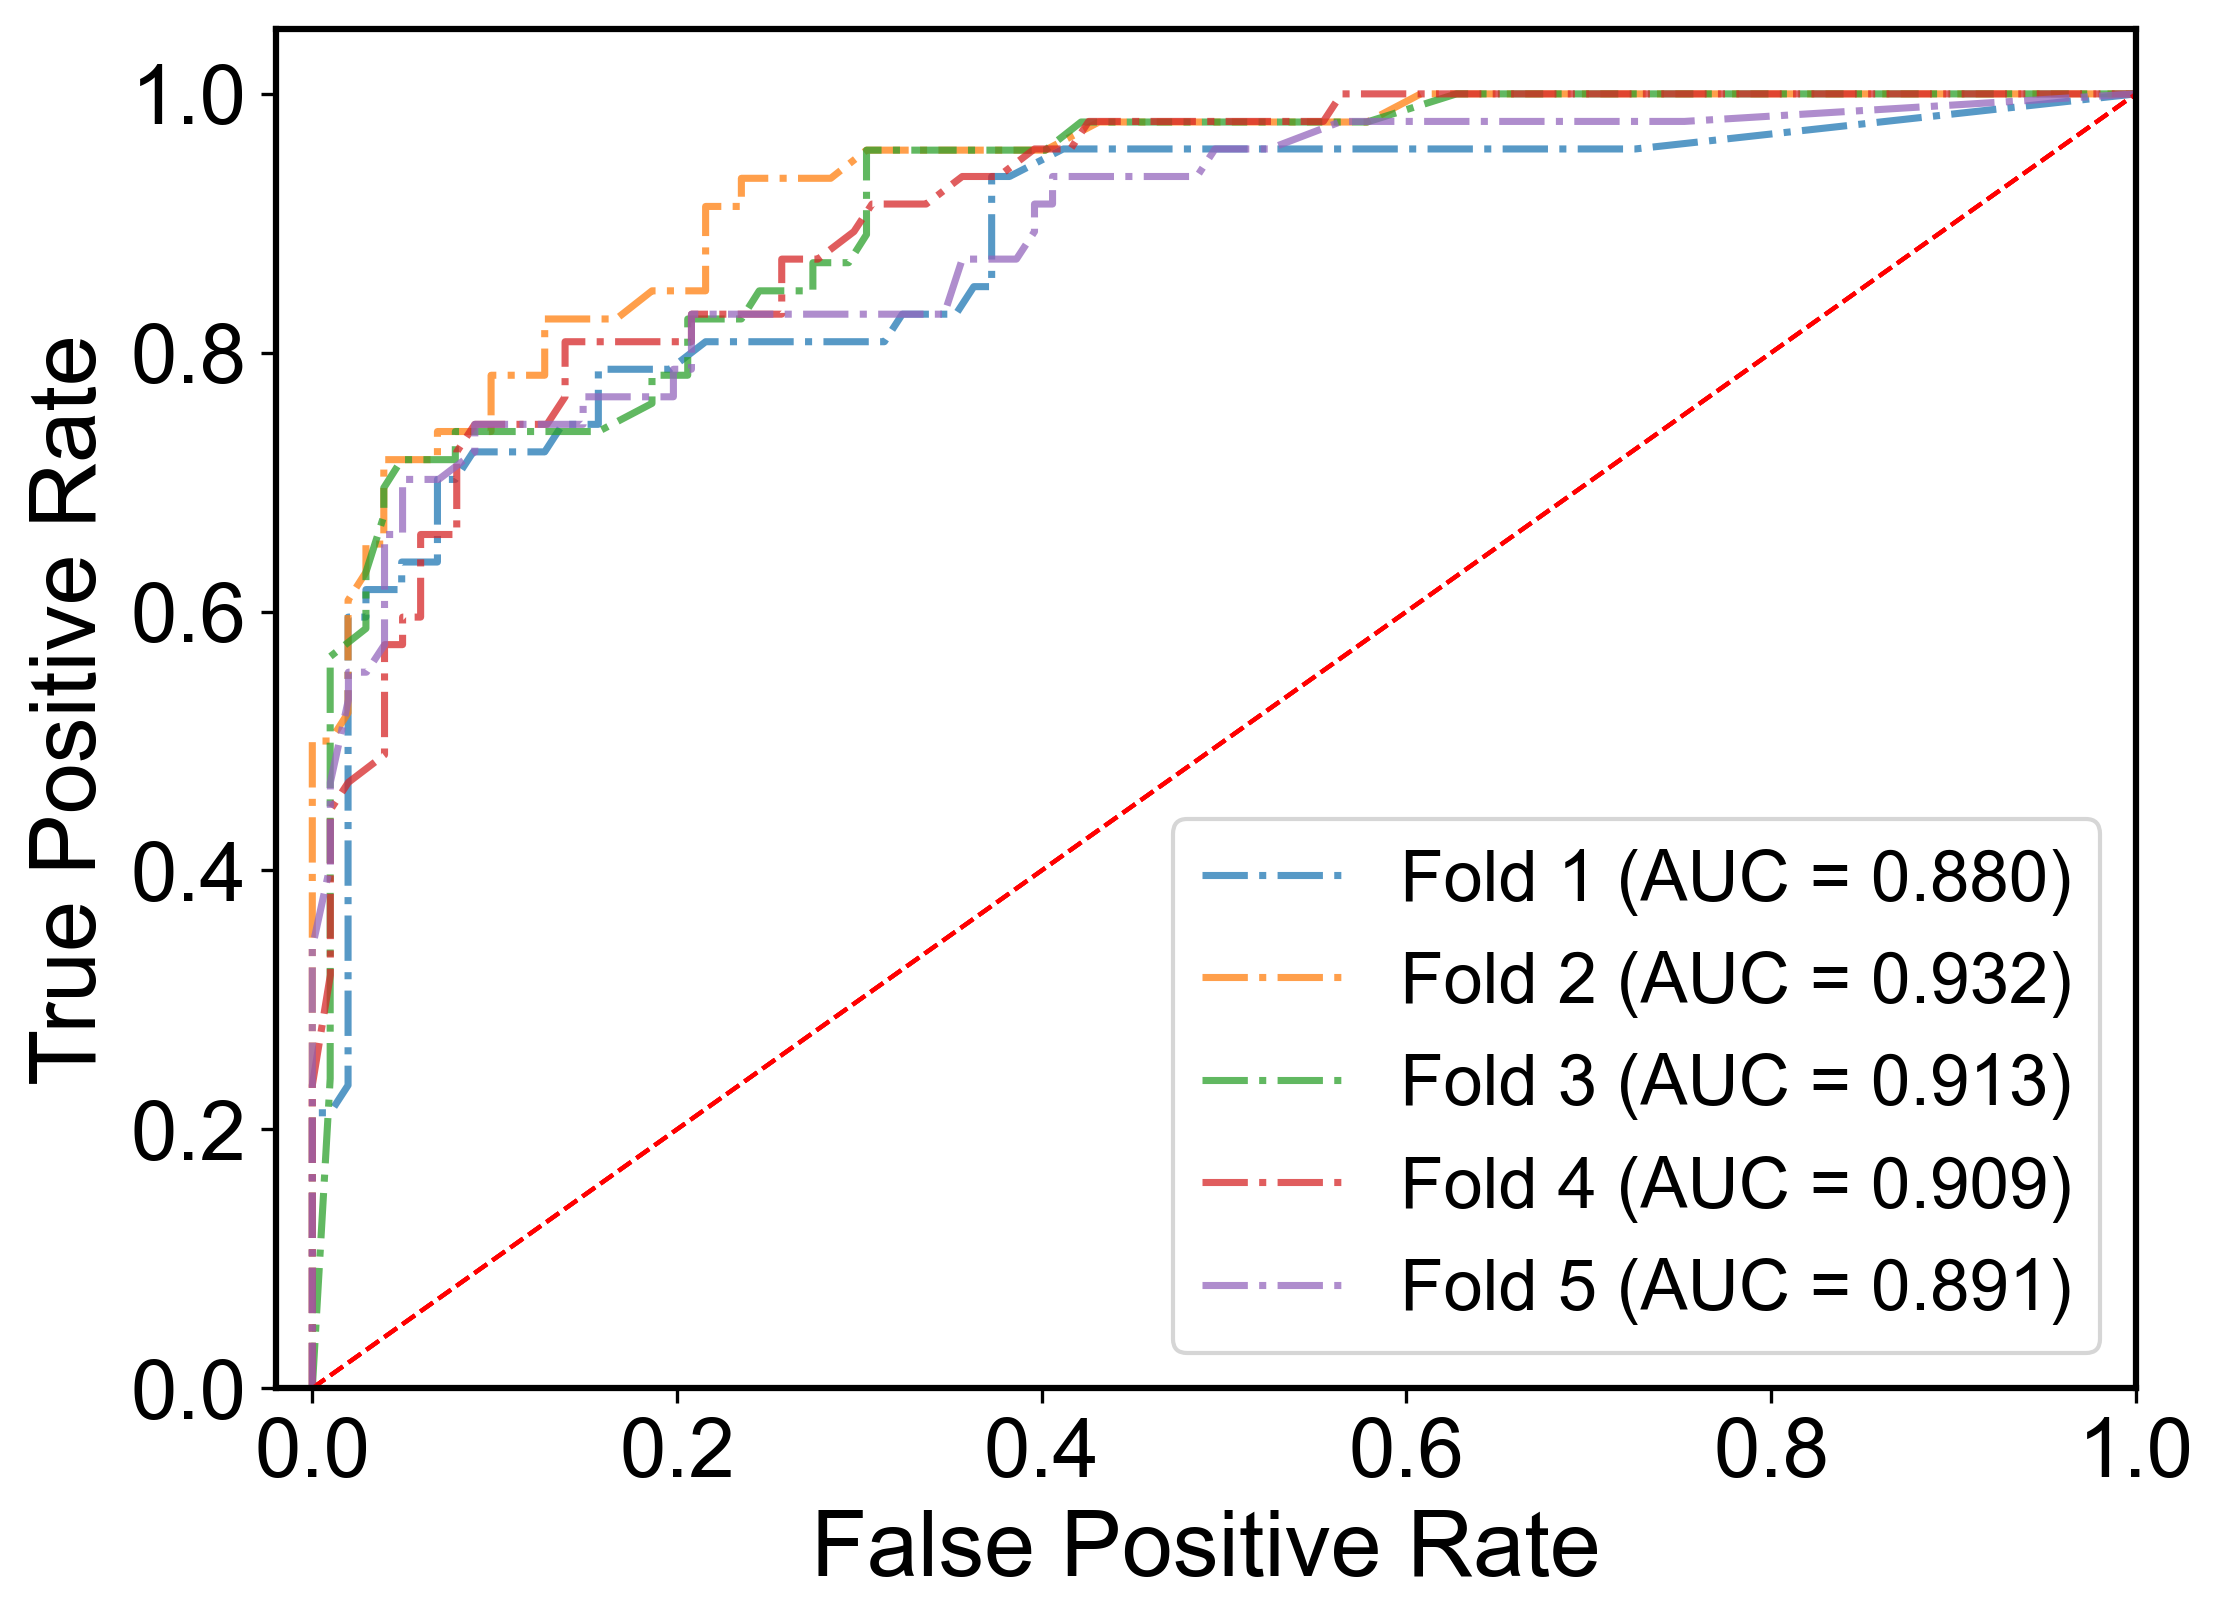

{'accuracy': 0.8528931616179939,
 'f1-score': 0.7575198616375814,
 'mcc': 0.6544348526799778,
 'roc_auc': 0.9047435442243688,
 'recall': 0.7296947271045328}

In [296]:
#！！！！！！
ext_result, ext_models = fold5_smote_ensemble_data(ext, X_ext, y)
ext_result

In [85]:
from joblib import dump
dump(ext_models, './model/slme_ext.joblib')

['slme_ext.joblib']

Fold 1 Accuracy: 0.8322147651006712 F1_Score: 0.7126436781609196  ROC_AUC: 0.8730705047976637
Fold 2 Accuracy: 0.8513513513513513 F1_Score: 0.7555555555555555  ROC_AUC: 0.9240196078431372
Fold 3 Accuracy: 0.8445945945945946 F1_Score: 0.7356321839080461  ROC_AUC: 0.9049445865302643
Fold 4 Accuracy: 0.8378378378378378 F1_Score: 0.7499999999999999  ROC_AUC: 0.9057299346955973
Fold 5 Accuracy: 0.8648648648648649 F1_Score: 0.7674418604651163  ROC_AUC: 0.8804508110385507


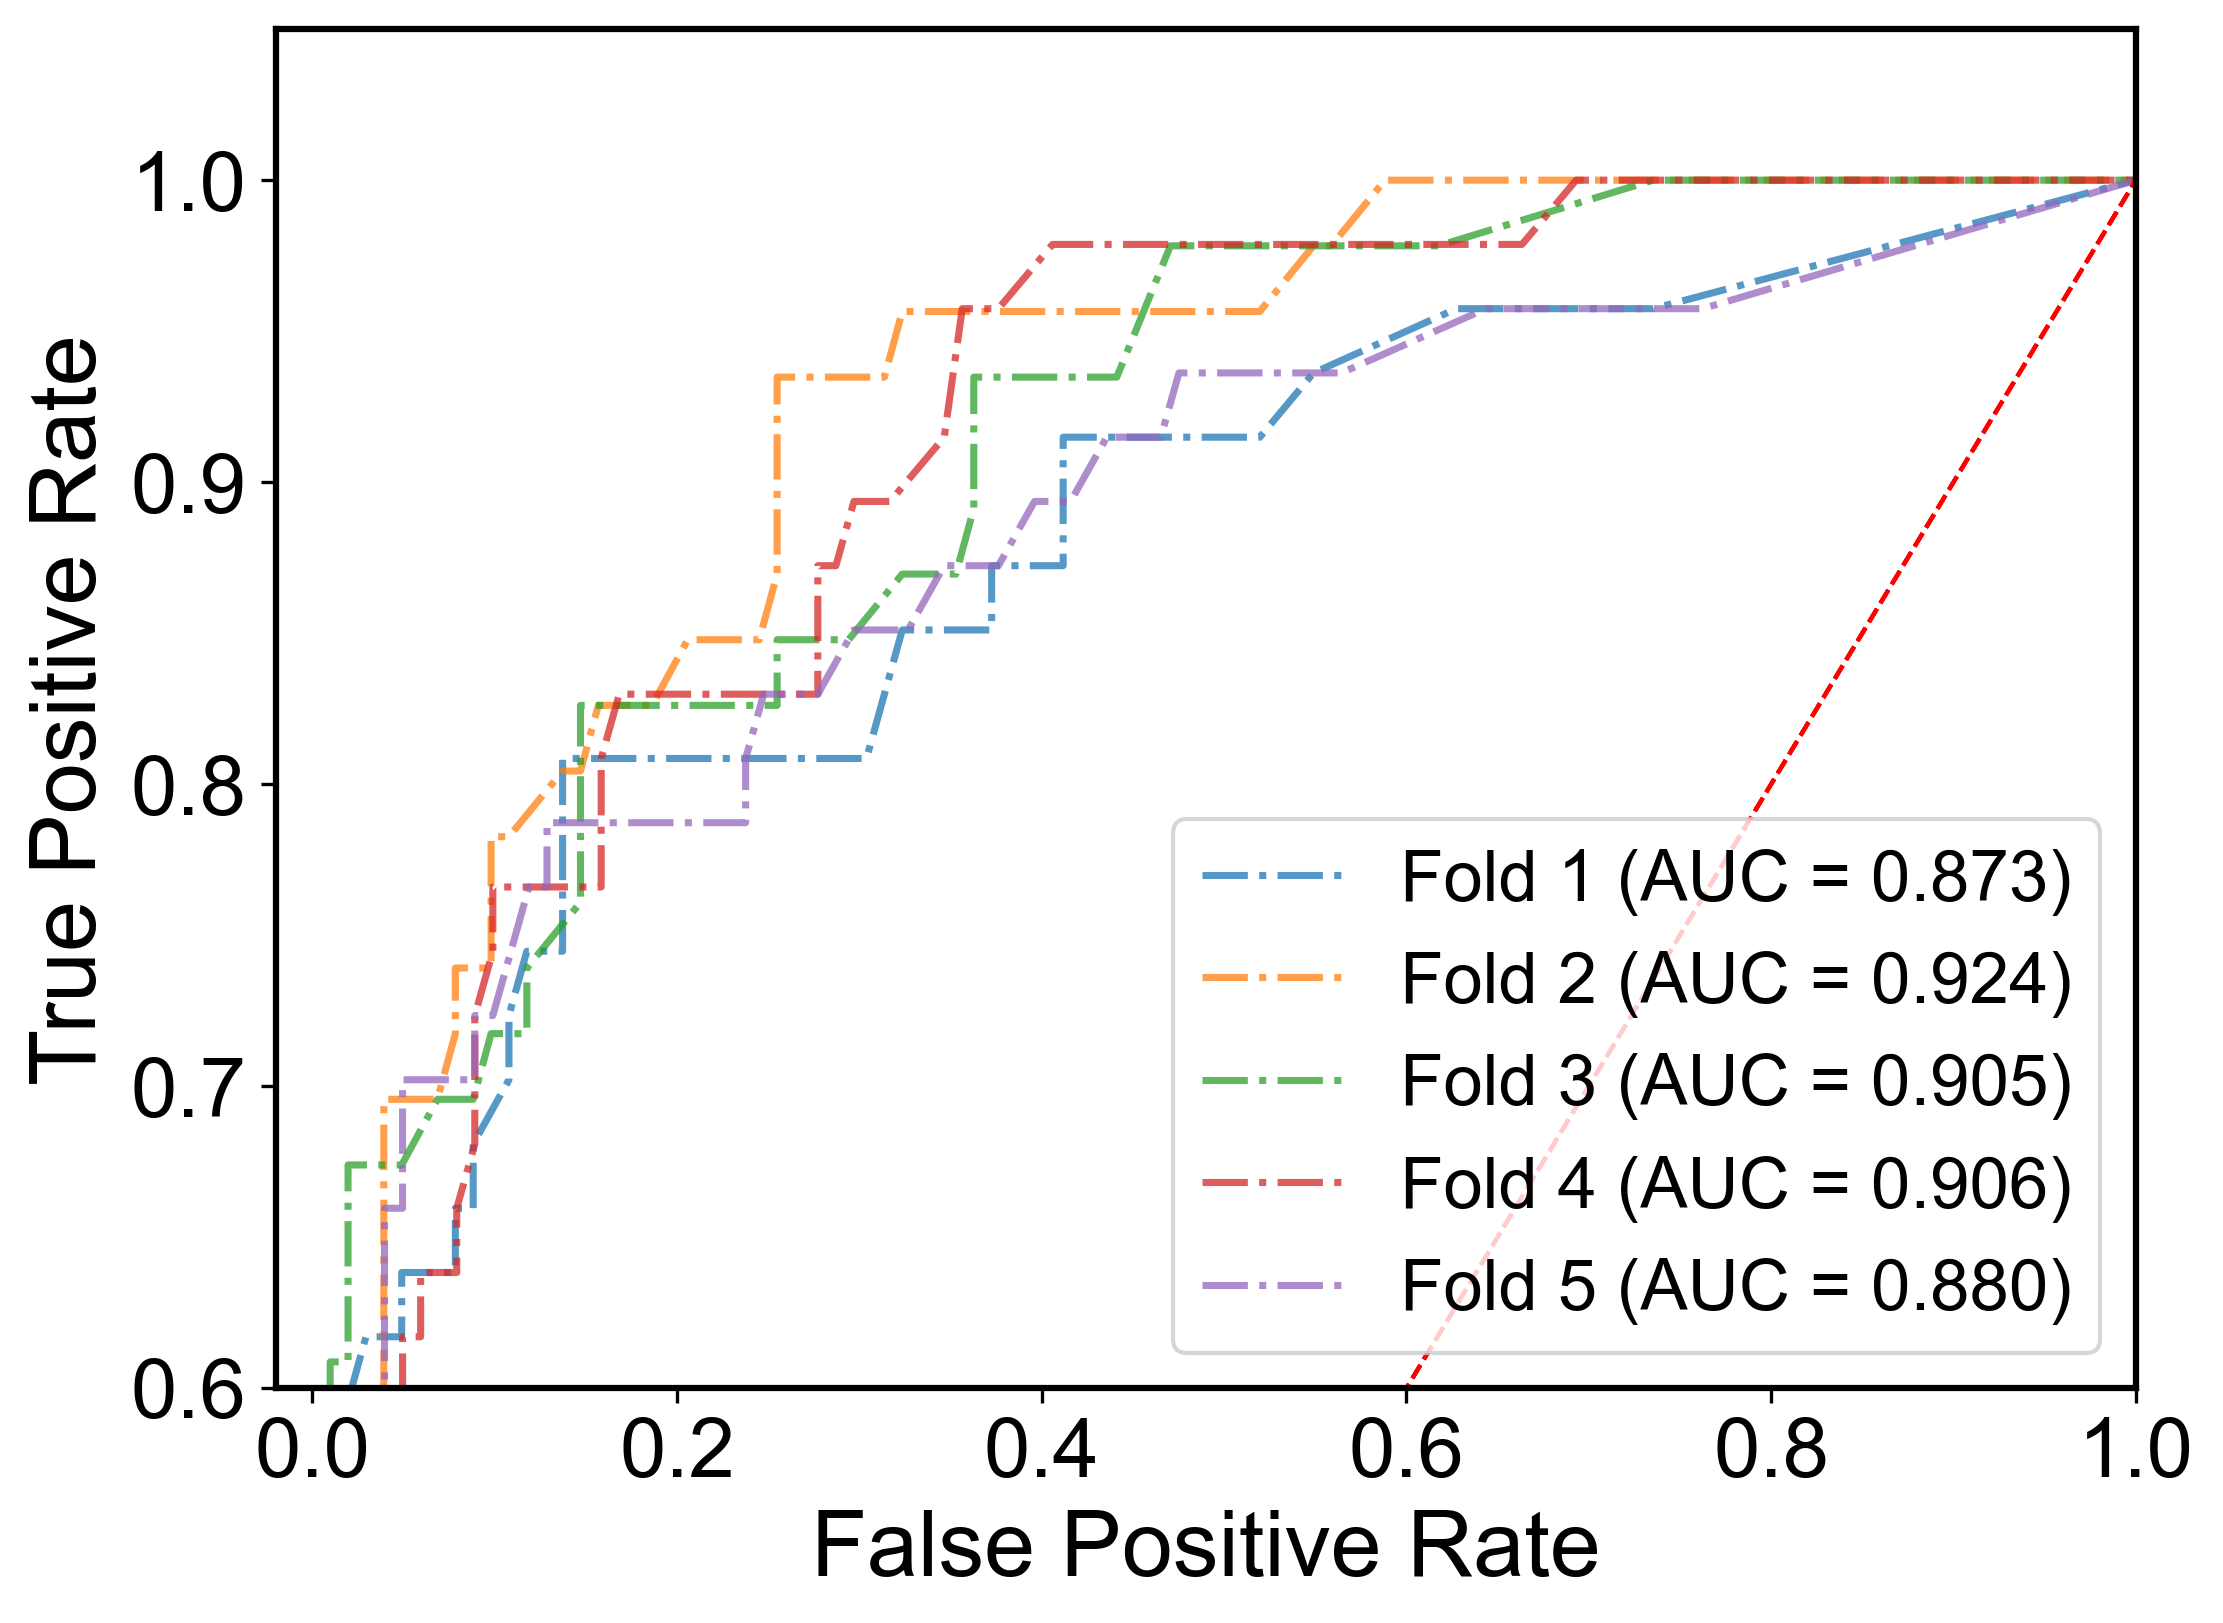

{'accuracy': 0.8461726827498641,
 'f1-score': 0.7442546556179275,
 'mcc': 0.6372007498148526,
 'roc_auc': 0.8976430889810427,
 'recall': 0.7124884366327473}

In [292]:
#no smote
ext2_result, ext2_models = fold5(ext, X_ext, y)
ext2_result

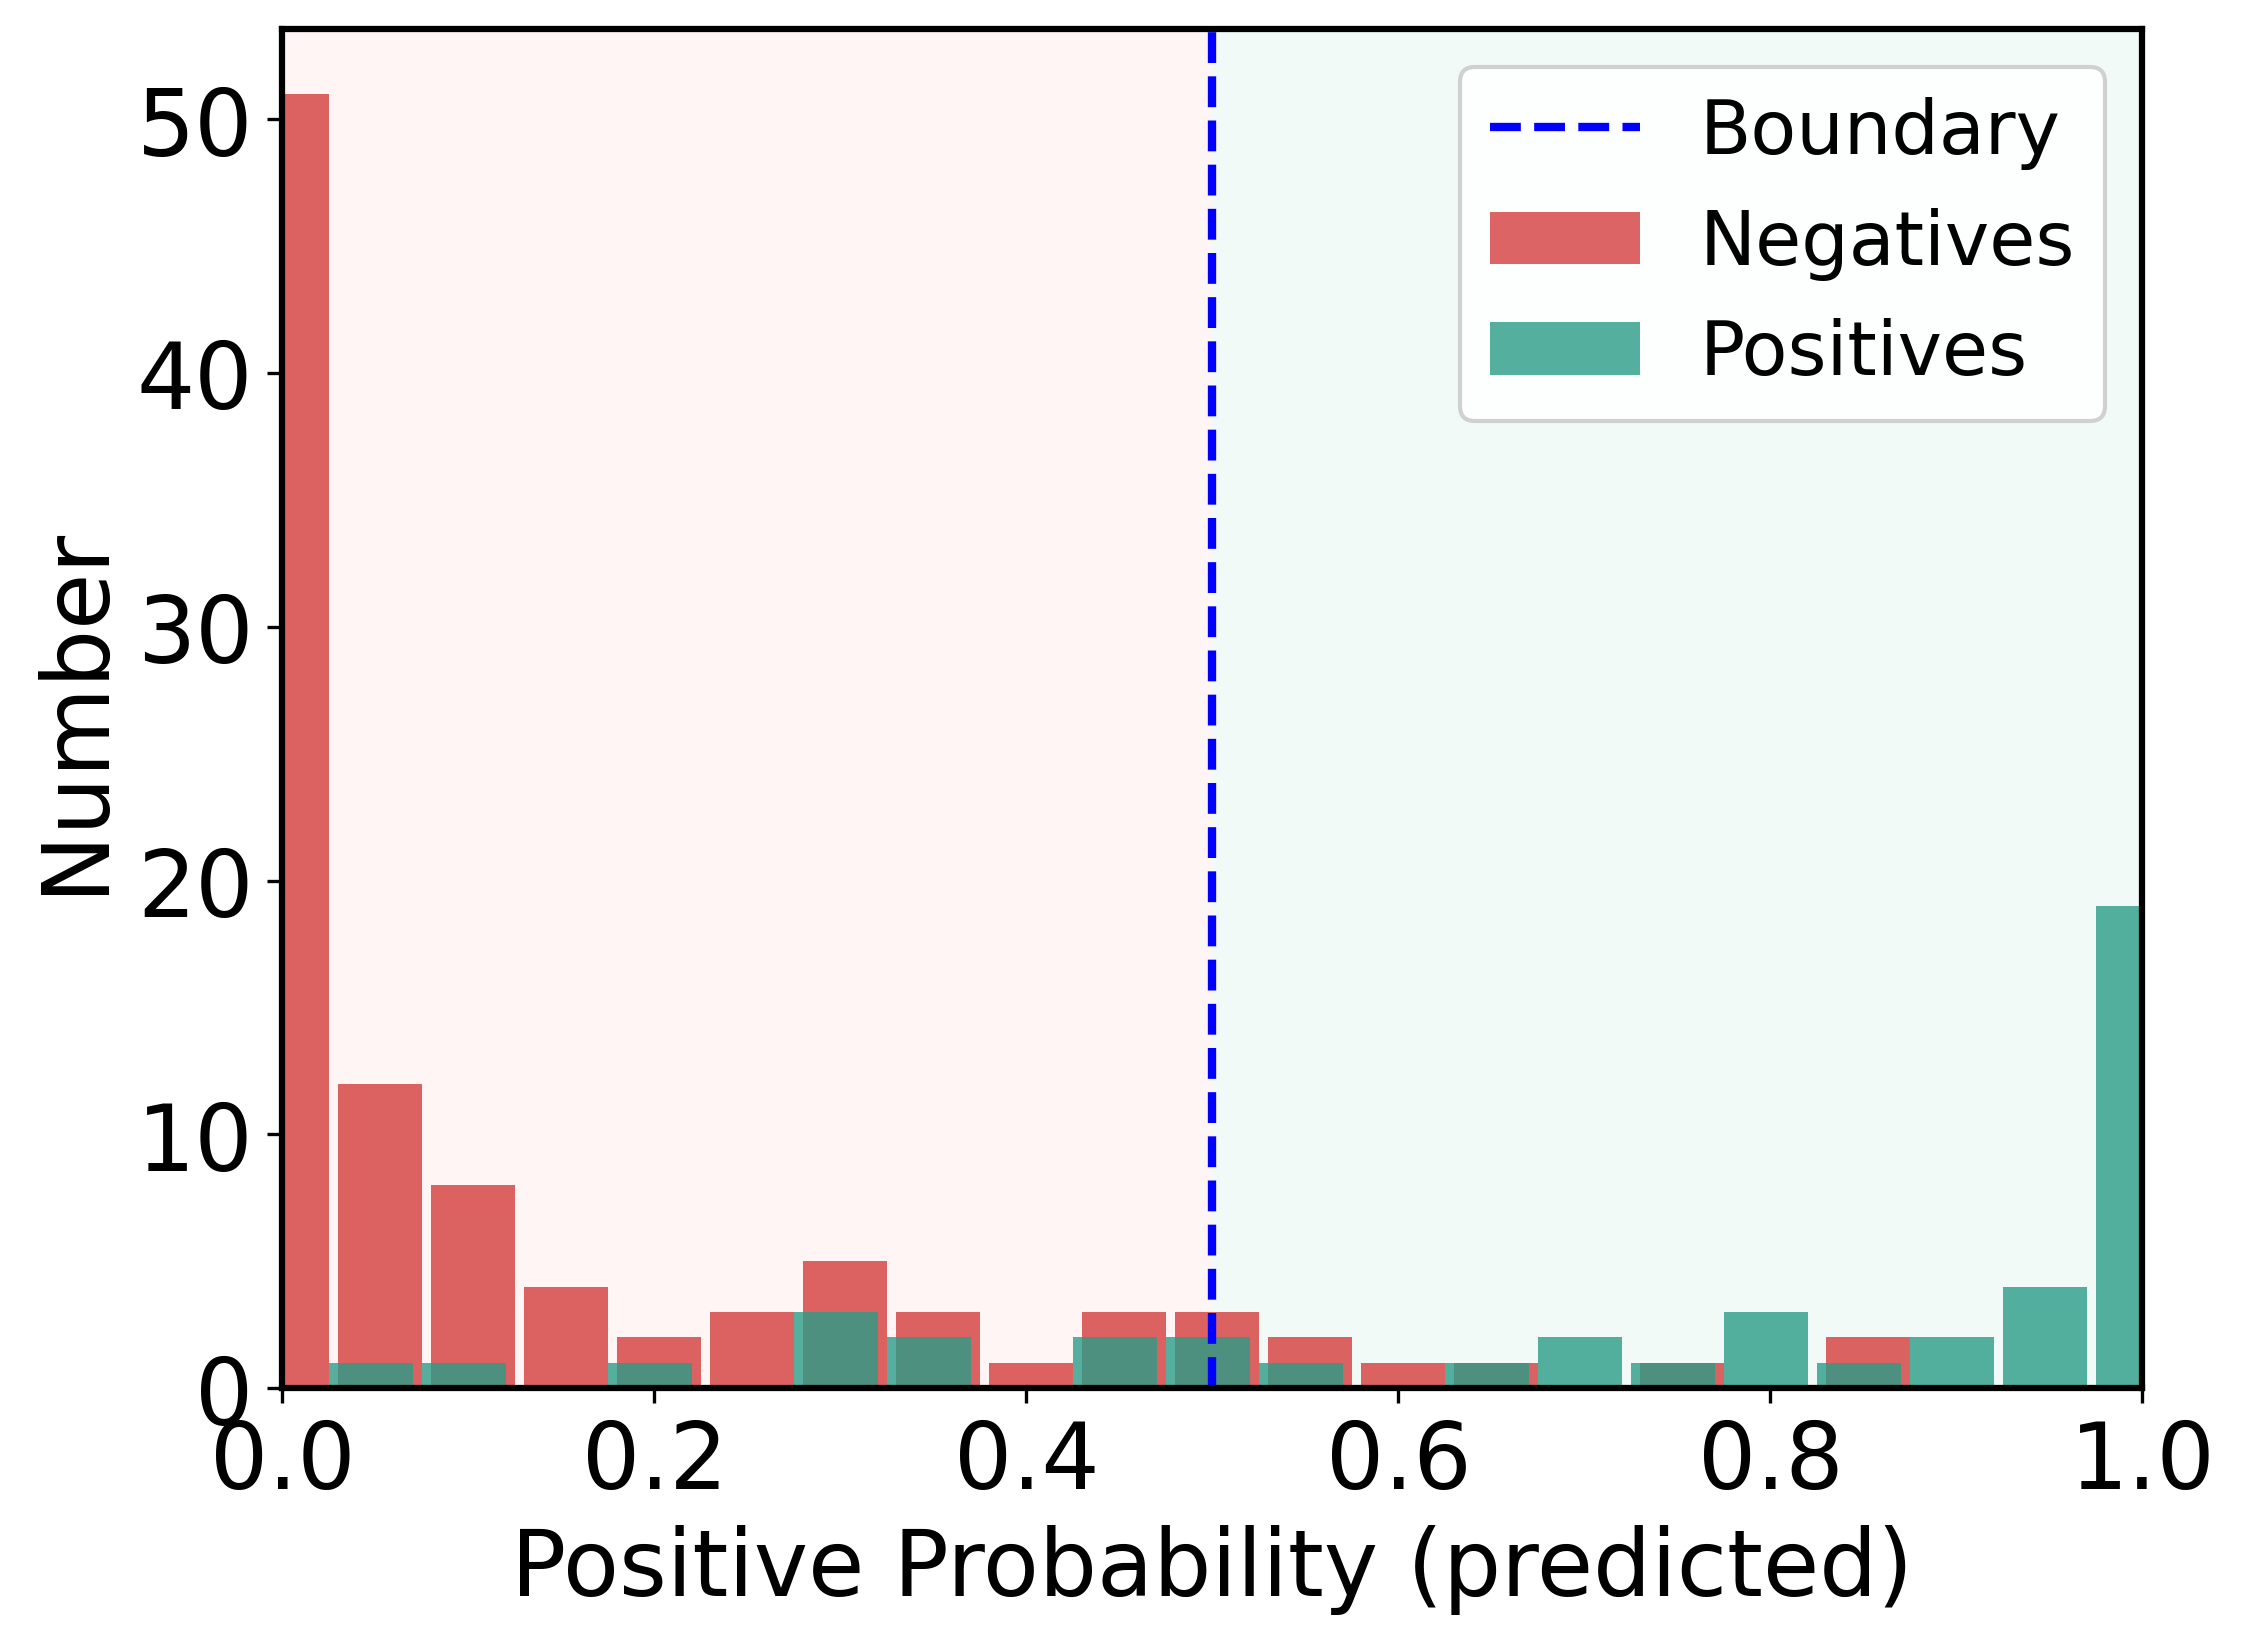

In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./data/ml_slme_data/fold1_predict_prob.csv')  
pos_probs = df[df['true_label'] == 1]['predict_proba'].values
neg_probs = df[df['true_label'] == 0]['predict_proba'].values

bins = np.linspace(0, 1, 21)
neg_counts, bin_edges = np.histogram(neg_probs, bins=bins)
pos_counts, _ = np.histogram(pos_probs, bins=bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 0.045  
offset = width * 0.5  

fig, ax = plt.subplots()
ax.axvspan(0, 0.5, facecolor='#ffecec', alpha=0.5)   
ax.axvspan(0.5, 1, facecolor='#e6f7f2', alpha=0.5)   
ax.bar(bin_centers - offset, neg_counts, width=width, alpha=0.8, 
        color='#d43d3d', linewidth=0.7, 
        label='Negatives')
ax.bar(bin_centers + offset, pos_counts, width=width, alpha=0.8, 
        color='#2a9c88', linewidth=0.7, 
        label='Positives')

ax.axvline(0.5, color='blue', linestyle='--', linewidth=2, label='Boundary')
ax.set_xlabel('Positive Probability (predicted)', fontsize=22)
ax.set_ylabel('Number', fontsize=22)

ax.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=18)
ax.set_xlim(0, 1)

ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=22)

#plt.savefig('./picture/slme_probability_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

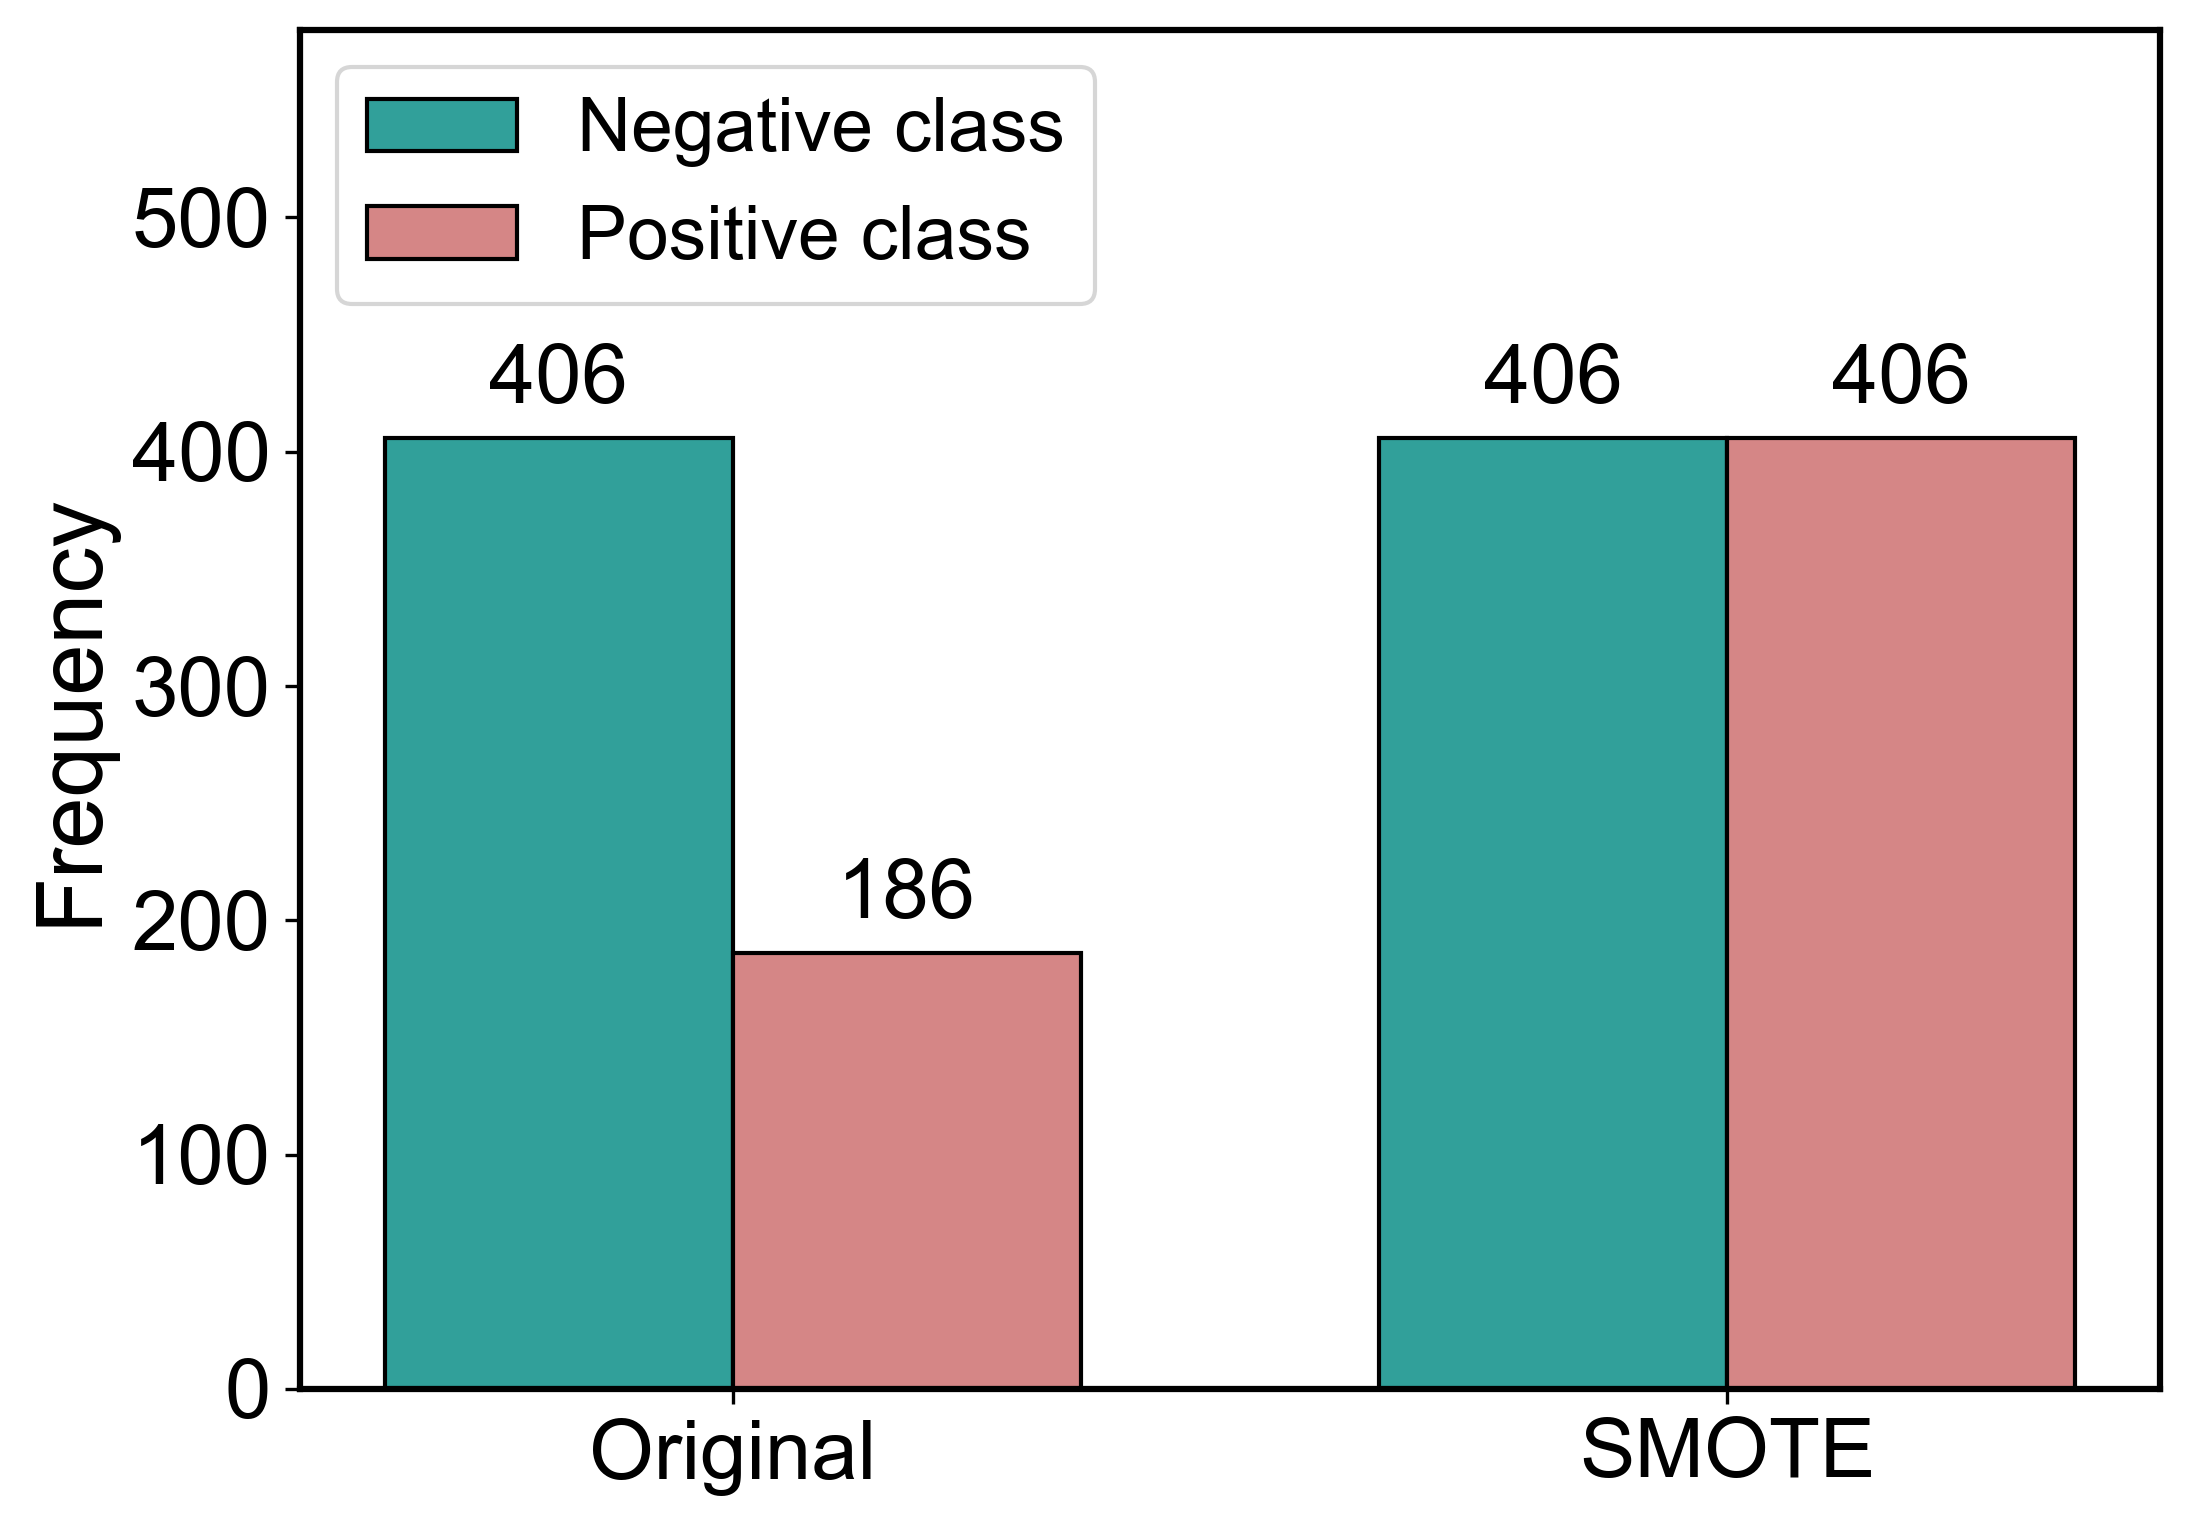

In [277]:
import matplotlib.pyplot as plt

original = {0: 406, 1: 186}
smote = {0: 406, 1: 406}

fig, ax = plt.subplots()
indices = list(original.keys())
width = 0.35  
categories = ['Original', 'SMOTE']
values_0 = [original[0], smote[0]]
values_1 = [original[1], smote[1]]

bars1 = ax.bar([i for i in indices], values_0, width, label='Negative class',
               color='#31A09A', edgecolor='black')
bars2 = ax.bar([i + width for i in indices], values_1, width, label='Positive class',
               color='#D58686', edgecolor='black')

ax.legend(fontsize=18, loc="upper left")
ax.set_ylabel('Frequency', fontsize=22)

ax.set_xticks([i + width / 2 for i in indices])
ax.set_xticklabels(categories, fontsize=22)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
            height + 8,  
            str(height),
            ha='center',
            va='bottom',
            fontsize=20)

ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('')

plt.ylim(0, 580)

plt.savefig('./picture/slme_smote_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
from joblib import load
ext_models = load('slme_ext.joblib')

In [59]:
ext_models[1]

ExtraTreesClassifier(n_jobs=-1, random_state=42)

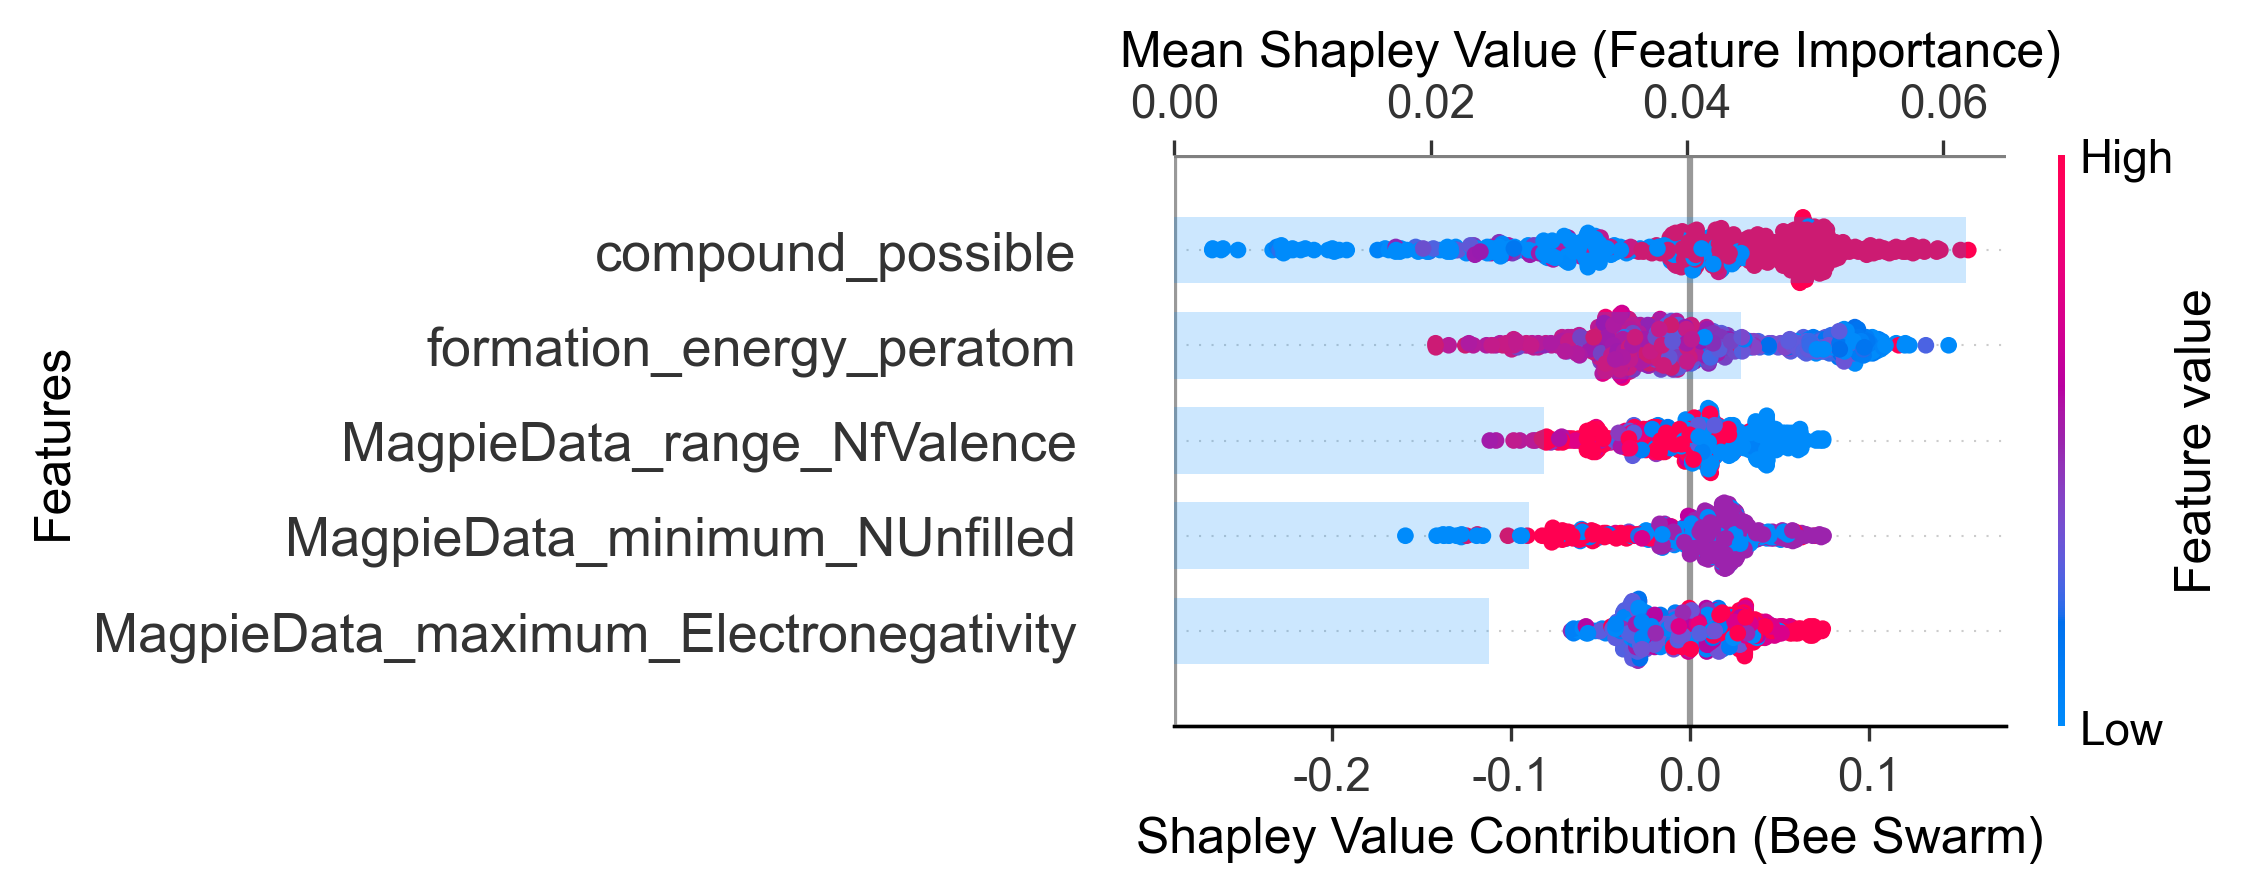

In [272]:
shap.summary_plot(
    shap_values_train[0], 
    X_train, 
    feature_names=feature_names,
    plot_type="dot", 
    show=False,
    max_display=5,
    color_bar=True
)

ax1 = plt.gca()
ax2 = ax1.twiny()
shap.summary_plot(
    shap_values_train[0], 
    X_train, 
    feature_names=feature_names,
    plot_type="bar", 
    show=False,
    max_display=5
)
plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  
ax2.axhline(y=5, color='gray', linestyle='-', linewidth=1.5) 
bars = ax2.patches  
for bar in bars:    
    bar.set_alpha(0.2)  
ax1.set_xlabel('Shapley Value Contribution (Bee Swarm)', fontsize=12)
ax2.set_xlabel('Mean Shapley Value (Feature Importance)', fontsize=12)
ax2.xaxis.set_ticks_position('top') 
ax2.xaxis.set_label_position('top')
plt.subplots_adjust(
    left=0.2,    
    right=0.75, 
    top=0.85,    
    bottom=0.15  
)
ax1.set_ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('./picture/slme_shap.png', bbox_inches='tight')
plt.show()

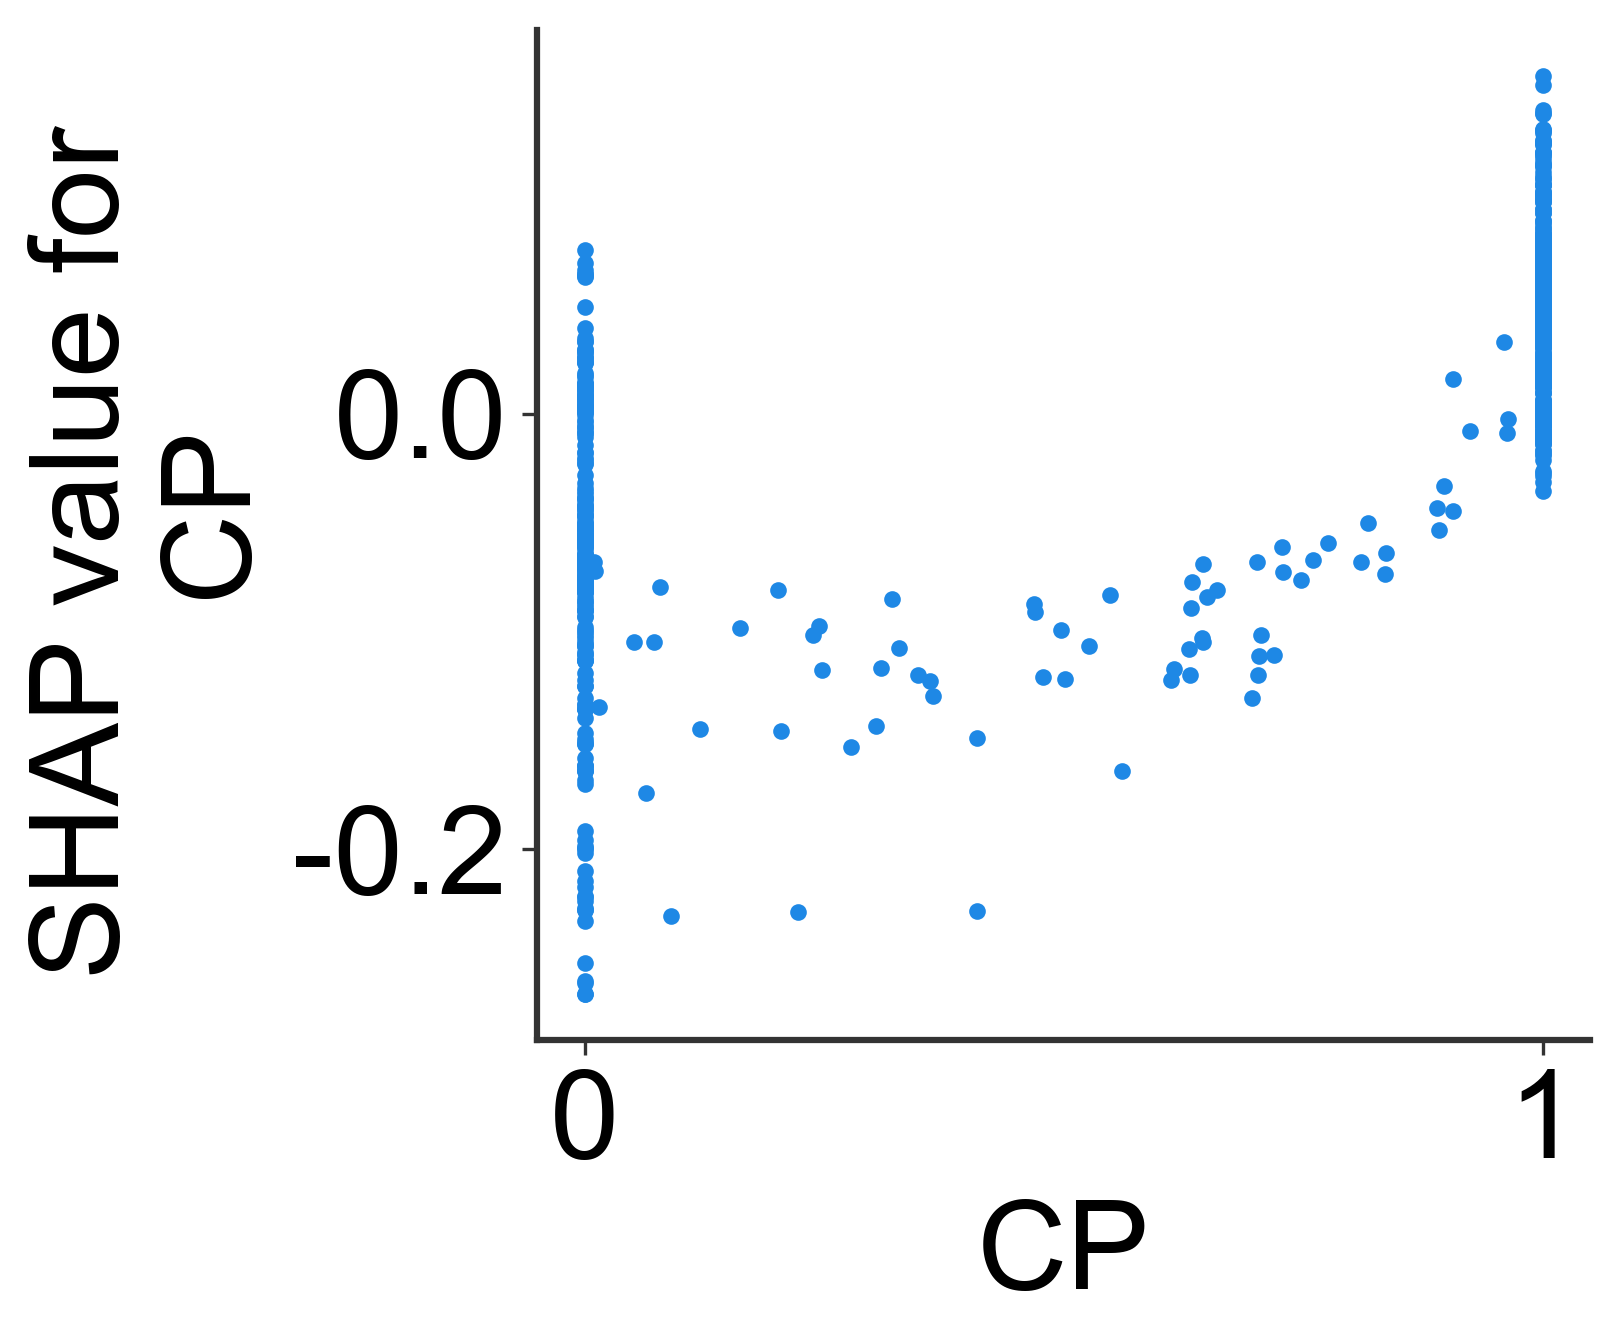

In [267]:
import matplotlib.pyplot as plt
import shap

shap.plots.scatter(
    shap_explanation[:, "compound_possible"], 
    hist=False,
    show=False  
)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

ax.tick_params(axis='both', which='major', labelsize=30)  
plt.setp(ax.get_xticklabels(), fontweight=550,color='black')  
plt.setp(ax.get_yticklabels(), fontweight=550,color='black')  

ax.set_xlabel("CP", fontsize=30,fontweight=550,color='black')
ax.set_ylabel("SHAP value for \n CP", fontsize=30, fontweight=550,color='black')
plt.tight_layout()
plt.savefig("./picture/slme_shap1.png", dpi=300, bbox_inches="tight")
plt.show()

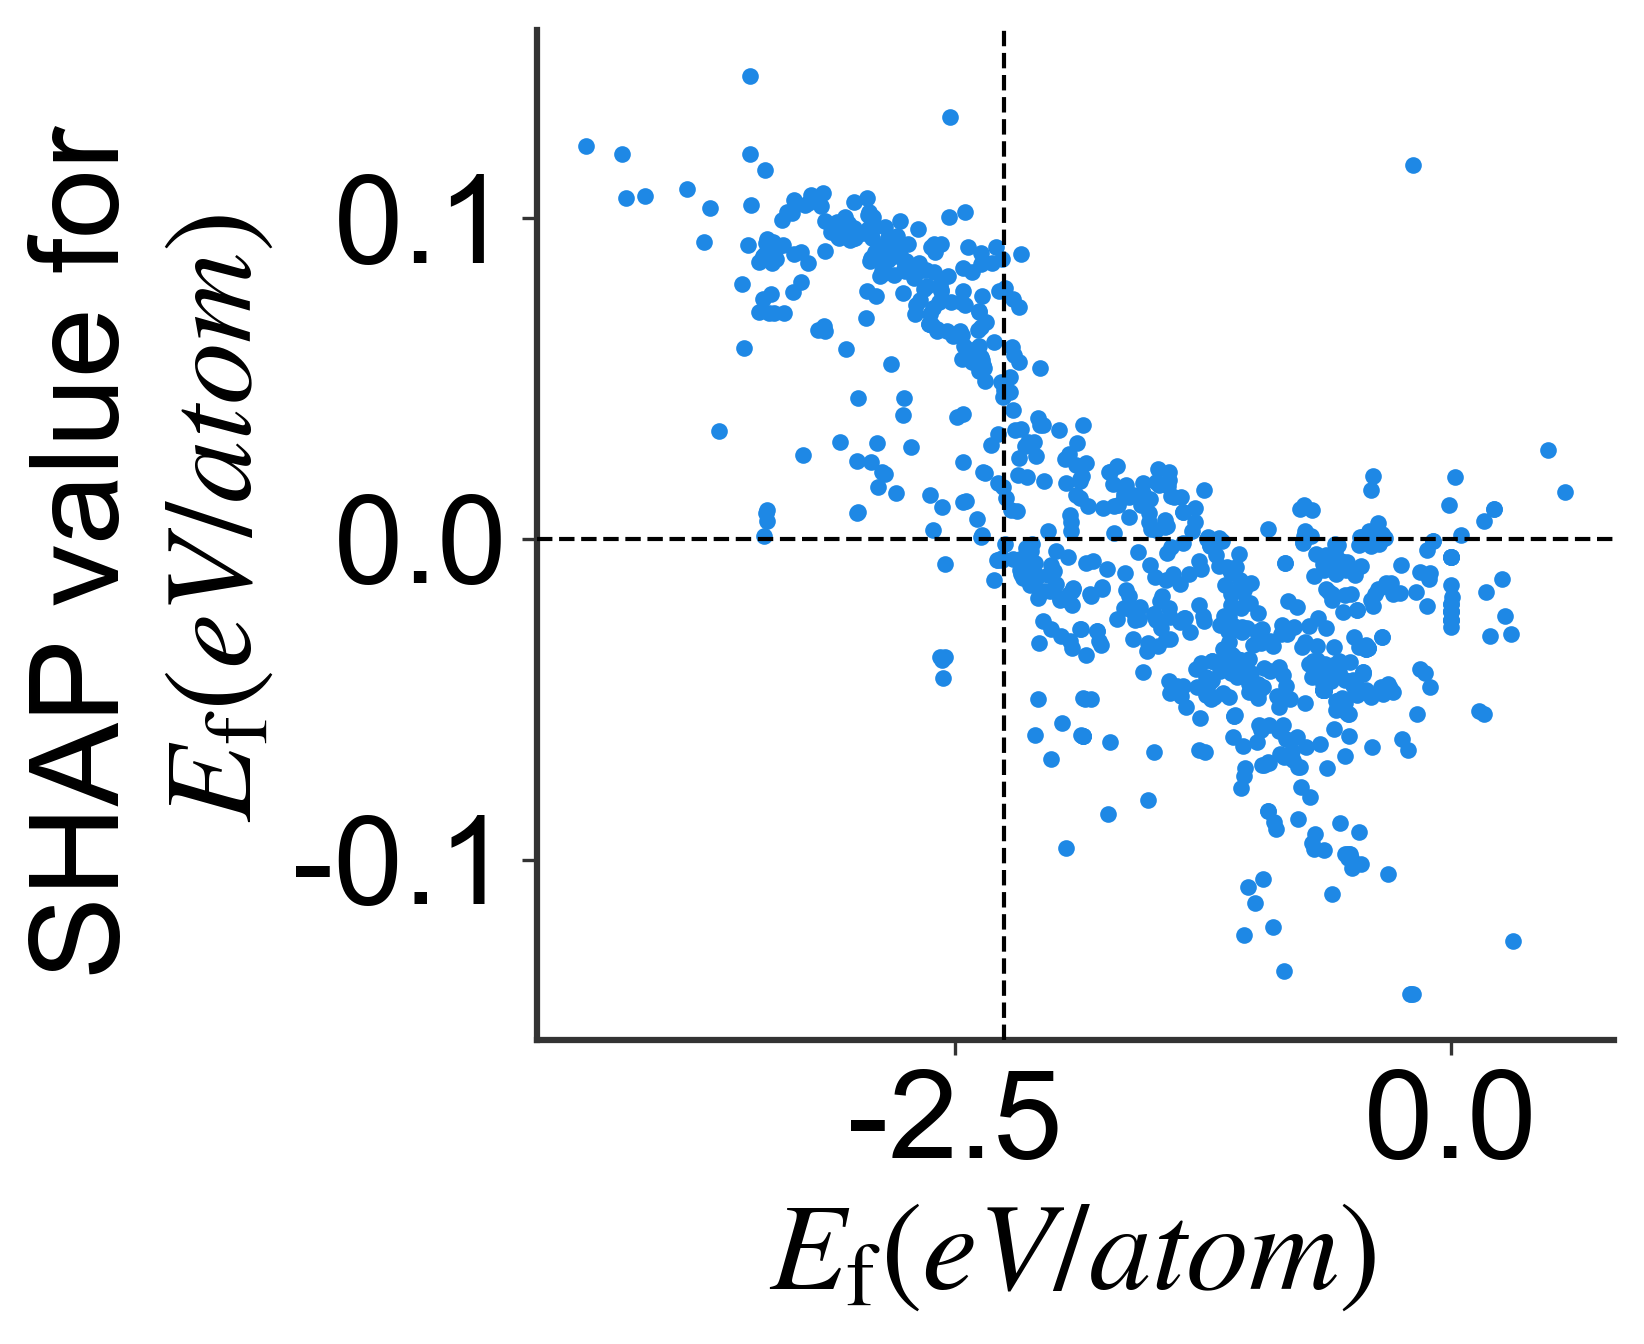

In [268]:
shap.plots.scatter(
    shap_explanation[:, "formation_energy_peratom"], 
    hist=False,
    show=False  
)

ax = plt.gca()

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

ax.tick_params(axis='both', which='major', labelsize=30)
plt.setp(ax.get_xticklabels(), fontweight=550,color='black')  
plt.setp(ax.get_yticklabels(), fontweight=550,color='black')

ax.set_ylabel("SHAP value for \n $E_{\mathrm{f}}  (eV/atom)$", fontsize=30,fontweight=550,color='black')
ax.set_xlabel(r"$E_{\mathrm{f}}  (eV/atom)$ ", fontsize=30,fontweight=550,color='black')
plt.tight_layout()
ax.axhline(y=0,color='black',linestyle='--',linewidth=1,zorder=3)
ax.axvline(x=-2.25,color='black',linestyle='--',linewidth=1,zorder=3)
plt.savefig("./picture/slme_shap2.png", dpi=300, bbox_inches="tight")
plt.show()

# predicting SLME and screening candidate space

In [36]:
data = pd.read_csv('./data/data_fm.csv')
data['spacegroup'] = 225
data

formula  number  formation_energy_peratom  spacegroup
0      Li2NaBF6       1                 -2.883512         225
1      Li2NaNF6       1                 -1.835910         225
2     Li2CuAlF6       1                 -2.525436         225
3      Li2CuPF6       1                 -2.062158         225
4     Li2CuCrF6       1                 -2.448179         225
...         ...     ...                       ...         ...
7032  Nd2LiCuF6       3                 -2.691447         225
7033  Nd2NaCuF6       3                 -2.696222         225
7034  Eu2LiCuF6       3                 -2.701771         225
7035  Tm2LiCuF6       3                 -2.611020         225
7036  Yb2LiCuF6       3                 -2.675711         225

[7037 rows x 4 columns]

In [37]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen.core import Composition
feature_calculators = MultipleFeaturizer([cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()
data['composition'] = data['formula'].map(Composition)
data_features = feature_calculators.featurize_dataframe(data,col_id='composition')

X_s = data_features[feature_labels]
#X_s = remove_collinear_features(X_s, 0.8)
X_s = pd.concat([data['spacegroup'],X_s ], axis=1)
X_s = pd.concat([data['formation_energy_peratom'],X_s ], axis=1)
X_s.columns = X_s.columns.str.replace(' ', '_')
X_s['compound_possible'] = X_s['compound_possible'].replace({True: 1, False: 0})
X_s = X_s.fillna(0)
feature_labels = X_s.columns

MultipleFeaturizer:   0%|          | 0/7037 [00:00<?, ?it/s]

In [38]:
features_ext =  ['formation_energy_peratom', 'MagpieData_minimum_Number', 'MagpieData_maximum_Number', 'MagpieData_range_Number', 
  'MagpieData_maximum_MeltingT', 'MagpieData_mean_MeltingT', 'MagpieData_avg_dev_MeltingT', 'MagpieData_range_Column',
  'MagpieData_maximum_Electronegativity', 'MagpieData_minimum_NsValence', 'MagpieData_maximum_NsValence', 'MagpieData_minimum_NpValence',
  'MagpieData_range_NpValence', 'MagpieData_mean_NdValence', 'MagpieData_minimum_NfValence', 'MagpieData_range_NfValence', 
  'MagpieData_mean_NfValence', 'MagpieData_maximum_NValence', 'MagpieData_range_NValence', 'MagpieData_avg_dev_NValence', 
  'MagpieData_minimum_NpUnfilled', 'MagpieData_minimum_NdUnfilled', 'MagpieData_mean_NdUnfilled', 'MagpieData_mode_NdUnfilled', 
  'MagpieData_maximum_NfUnfilled', 'MagpieData_minimum_NUnfilled', 'MagpieData_mode_NUnfilled', 'MagpieData_minimum_GSbandgap', 
  'MagpieData_maximum_GSbandgap', 'MagpieData_range_GSbandgap', 'MagpieData_maximum_GSmagmom', 'compound_possible'] 

In [39]:
X_s = X_s[features_ext]
X_s

formation_energy_peratom  MagpieData_minimum_Number  \
0                    -2.883512                        3.0   
1                    -1.835910                        3.0   
2                    -2.525436                        3.0   
3                    -2.062158                        3.0   
4                    -2.448179                        3.0   
...                        ...                        ...   
7032                 -2.691447                        3.0   
7033                 -2.696222                        9.0   
7034                 -2.701771                        3.0   
7035                 -2.611020                        3.0   
7036                 -2.675711                        3.0   

      MagpieData_maximum_Number  MagpieData_range_Number  \
0                          11.0                      8.0   
1                          11.0                      8.0   
2                          29.0                     26.0   
3                          29.0                     26.0   
4                          29.0                     26.0   
...                         ...                      ...   
7032                       60.0                     57.0   
7033                       60.0                     51.0   
7034                       63.0                     60.0   
7035                       69.0                     66.0   
7036                       70.0                     67.0   

      MagpieData_maximum_MeltingT  MagpieData_mean_MeltingT  \
0                         2348.00                   394.725   
1                          453.69                   166.230   
2                         1357.77                   351.962   
3                         1357.77                   290.345   
4                         2180.00                   476.615   
...                           ...                       ...   
7032                      1357.77                   472.046   
7033                      1357.77                   463.764   
7034                      1357.77                   432.246   
7035                      1818.00                   576.846   
7036                      1357.77                   431.646   

      MagpieData_avg_dev_MeltingT  MagpieData_range_Column  \
0                        414.2410                     16.0   
1                        155.9120                     16.0   
2                        358.1544                     16.0   
3                        284.2140                     16.0   
4                        516.9080                     16.0   
...                           ...                      ...   
7032                     505.9264                     16.0   
7033                     510.8956                     16.0   
7034                     454.4952                     16.0   
7035                     652.6464                     16.0   
7036                     453.7752                     16.0   

      MagpieData_maximum_Electronegativity  MagpieData_minimum_NsValence  \
0                                     3.98                           1.0   
1                                     3.98                           1.0   
2                                     3.98                           1.0   
3                                     3.98                           1.0   
4                                     3.98                           1.0   
...                                    ...                           ...   
7032                                  3.98                           1.0   
7033                                  3.98                           1.0   
7034                                  3.98                           1.0   
7035                                  3.98                           1.0   
7036                                  3.98                           1.0   

      MagpieData_maximum_NsValence  MagpieData_minimum_NpValence  \
0                              2.0                           0.0   
1

In [40]:
slme = pd.DataFrame(columns=['formula','number'])
slme['formula'] = data['formula']
slme['number'] = data['number']

In [44]:
from joblib import load
ext_models = load('slme_ext.joblib')

In [48]:
%%time
# ensemble predict
y_pred_ensemble = np.array([model.predict(X_s) for model in ext_models]).T
slme['slme'] = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=y_pred_ensemble)  

CPU times: user 1.5 s, sys: 150 ms, total: 1.65 s
Wall time: 699 ms


In [46]:
slme

formula  number  slme
0      Li2NaBF6       1     0
1      Li2NaNF6       1     0
2     Li2CuAlF6       1     1
3      Li2CuPF6       1     1
4     Li2CuCrF6       1     1
...         ...     ...   ...
7032  Nd2LiCuF6       3     0
7033  Nd2NaCuF6       3     0
7034  Eu2LiCuF6       3     0
7035  Tm2LiCuF6       3     1
7036  Yb2LiCuF6       3     1

[7037 rows x 3 columns]

In [47]:
slme['slme'].value_counts()

slme
0    4577
1    2460
Name: count, dtype: int64

In [132]:
screen = slme.loc[slme['slme']==1, ['formula', 'number']]
screen

formula  number
2      Li2CuAlF6       1
3       Li2CuPF6       1
4      Li2CuCrF6       1
7      Li2CuGaF6       1
8      Li2CuAsF6       1
...          ...     ...
7009  Tl2CaYbBr6       2
7019   Hg2LiCuF6       3
7020   Pb2LiNaF6       3
7035   Tm2LiCuF6       3
7036   Yb2LiCuF6       3

[2460 rows x 2 columns]

In [134]:
screen.to_csv('./data/screen_slme.csv',index=False)